## Trabalho CPE722 - Treinamento Supervisionado 

Autor: Micael Veríssimo de Araújo

e-mail: micaelvero@hotmail.com

Utilizar o trainamento supervisionado exposto em sala na tentativa de obter uma classificação sinal (Higgs) e background ($t\overline{t}$) no canal $WH \to l \nu b \overline{b}$

## Load all libraries and data


In [1]:
# import all necessay library
%time
import numpy as np
from numpy import linalg as LA
from functions import ClusterMerits, AuxiliarFunctions
from sklearn import preprocessing
from sklearn.datasets.samples_generator import make_blobs
from scipy.stats import norm
import matplotlib.mlab as mlab
from sklearn import preprocessing
from sklearn import metrics
import joblib

from functions import SupervisedKohonen
from sklearn import cross_validation

from pandas_ml import ConfusionMatrix

import matplotlib.pyplot as plt
%matplotlib inline

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.01 µs


/home/micael/.virtualenvs/MyAnalysis/local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# load the data and little data
%time
data_path = '/home/micael/MyWorkspace/DATA'
path_tosave = data_path+'/'+'Plots'

# load signal
signal = np.load(data_path+'/'+'lvbb125Matrix.npy')[0:5000,:]
signal_part = np.load(data_path+'/'+'lvbb125Matrix.npy')[0:250,:]
signal_trgt = (np.ones(signal.shape[0])).astype(int)

# load bkg
ttbar = np.load(data_path+'/'+'TTbarMatrix.npy')

ttbar_part = np.load(data_path+'/'+'TTbarMatrix.npy')[0:250,:]
bkg = ttbar
bkg_trgt = (np.zeros(bkg.shape[0])).astype(int)

#to make a dataset and target
data = np.append(signal,bkg,axis=0)
print 'data antes', data.shape
data = np.delete(data,11,axis=1)
print 'data depois',data.shape

little_data = np.append(signal_part,ttbar_part,axis=0)
trgt = np.append(signal_trgt,bkg_trgt,axis=0).astype(int)#signal_scd
trgt2 = trgt[:,np.newaxis] 

# to make correlation matrix
data_trgt = np.append(data,trgt2,axis=1)
#print data.shape
print data_trgt.shape

trgt.shape

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.91 µs
data antes (10000, 24)
data depois (10000, 23)
(10000, 24)


(10000,)

## K-Means para estimar a quantidade de clusters para sinal e background separadamente, porém com mesmos índices de treinamento e teste.

In [10]:
from sklearn.cluster import KMeans
n_folds = 10
n_clusters = 12

CVO = cross_validation.StratifiedKFold(signal_trgt,n_folds)
CVO = list(CVO)

F_in_signal = np.zeros([n_folds,len(range(2,n_clusters))])
#F_in_ttbar = np.zeros([n_folds,len(range(2,n_clusters))])
sil_signal = np.zeros([n_folds,len(range(2,n_clusters))])
#sil_ttbar = np.zeros([n_folds,len(range(2,n_clusters))])


for icluster in range(2,n_clusters):    
    print '===================',icluster,'=========================='
    for ifold in range(n_folds):
        train_id, test_id = CVO[ifold]

        scale_signal = preprocessing.StandardScaler().fit(signal[train_id])
        

        norm_signal = scale_signal.transform(signal)

        kmeans_signal = KMeans(n_clusters=icluster, random_state=0).fit(norm_signal[train_id])
        
    
        output_kmeans_signal = kmeans_signal.predict(norm_signal)
        
    
        cluster_list_signal = []
        for i in range(len(np.unique(output_kmeans_signal))):
            cluster_list_signal.append(norm_signal[output_kmeans_signal==i])
        
        sil_signal[ifold,icluster-2] = metrics.silhouette_score(norm_signal[test_id],
                                                                output_kmeans_signal[test_id])
        
        F_in_signal[ifold,icluster-2] = ClusterMerits.DispIntraClass(cluster_list_signal)
        
    
print 'Done!'

=================== 2 ==========================
=================== 3 ==========================
=================== 4 ==========================
=================== 5 ==========================
=================== 6 ==========================
=================== 7 ==========================
=================== 8 ==========================
=================== 9 ==========================
=================== 10 ==========================
=================== 11 ==========================
Done!


In [11]:

F_in_ttbar = np.zeros([n_folds,len(range(2,n_clusters))])

sil_ttbar = np.zeros([n_folds,len(range(2,n_clusters))])



for icluster in range(2,n_clusters):    
    print '===================',icluster,'=========================='
    for ifold in range(n_folds):
        train_id, test_id = CVO[ifold]
        
        scale_ttbar = preprocessing.StandardScaler().fit(bkg[train_id])
        
        norm_ttbar = scale_signal.transform(bkg)

                    
            
        kmeans_ttbar = KMeans(n_clusters=icluster, random_state=0).fit(norm_ttbar[train_id])
    
    
        output_kmeans_ttbar = kmeans_ttbar.predict(norm_ttbar)
        
            
        cluster_list_ttbar = []
        for i in range(len(np.unique(output_kmeans_ttbar))):
            cluster_list_ttbar.append(norm_ttbar[output_kmeans_ttbar==i])
            
        
        sil_ttbar[ifold,icluster-2] = metrics.silhouette_score(norm_ttbar[test_id],
                                                                output_kmeans_ttbar[test_id])
        
        F_in_ttbar[ifold,icluster-2] = ClusterMerits.DispIntraClass(cluster_list_ttbar)
        
print 'Done!'

=================== 2 ==========================
=================== 3 ==========================
=================== 4 ==========================
=================== 5 ==========================
=================== 6 ==========================
=================== 7 ==========================
=================== 8 ==========================
=================== 9 ==========================
=================== 10 ==========================
=================== 11 ==========================
Done!


In [12]:
mean_sil_signal = np.zeros([sil_signal.shape[1],])
sigma_sil_signal = np.zeros([sil_signal.shape[1],])

for i in range(mean_sil_signal.shape[0]):
    mean_sil_signal[i] = np.mean(sil_signal[:,i])
    sigma_sil_signal[i] = np.sqrt(np.var(sil_signal[:,i]))

mean_sil_ttbar = np.zeros([sil_ttbar.shape[1],])
sigma_sil_ttbar = np.zeros([sil_ttbar.shape[1],])

for i in range(mean_sil_ttbar.shape[0]):
    mean_sil_ttbar[i] = np.mean(sil_ttbar[:,i])
    sigma_sil_ttbar[i] = np.sqrt(np.var(sil_ttbar[:,i]))
    
mean_Fin_signal = np.zeros([F_in_signal.shape[1],])
sigma_Fin_signal = np.zeros([F_in_signal.shape[1],])

for i in range(mean_Fin_signal.shape[0]):
    mean_Fin_signal[i] = np.mean(F_in_signal[:,i])
    sigma_Fin_signal[i] = np.sqrt(np.var(F_in_signal[:,i]))

mean_Fin_ttbar = np.zeros([F_in_ttbar.shape[1],])
sigma_Fin_ttbar = np.zeros([F_in_ttbar.shape[1],])

for i in range(mean_Fin_ttbar.shape[0]):
    mean_Fin_ttbar[i] = np.mean(F_in_ttbar[:,i])
    sigma_Fin_ttbar[i] = np.sqrt(np.var(F_in_ttbar[:,i]))
x = np.array([2,3,4,5,6,7,8,9,10,11])

In [16]:
sigma_Fin_ttbar

array([   2.80195161,    1.43413726,    1.56555211,    2.36980486,
         16.18534053,   17.02384209,   27.75065936,   18.38517815,
        135.81938237,   10.20164821])

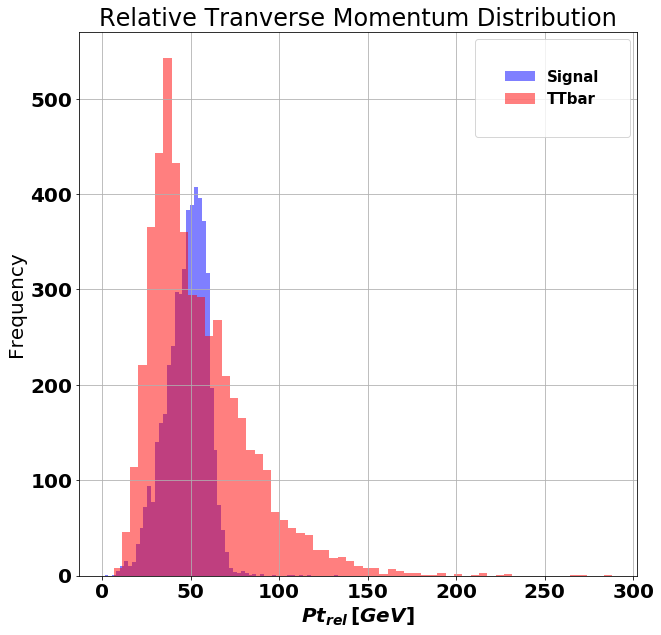

In [9]:
plt.rc('legend', **{'fontsize':15})
plt.rc('font', weight='bold', size=20)
plt.figure(figsize=(10,10))
plt.hist(data[:,22][trgt==1],60,color='b',label='Signal',alpha=0.5)
plt.hist(data[:,22][trgt==0],60,color='r',label='TTbar',alpha=0.5)
plt.grid()
plt.title('Relative Tranverse Momentum Distribution')
plt.xlabel(r'$Pt_{rel}\,[GeV]$')
plt.ylabel('Frequency')
plt.legend(borderpad=2)
plt.savefig(path_tosave+'/'+'plot_PtRel.pdf')
plt.show()


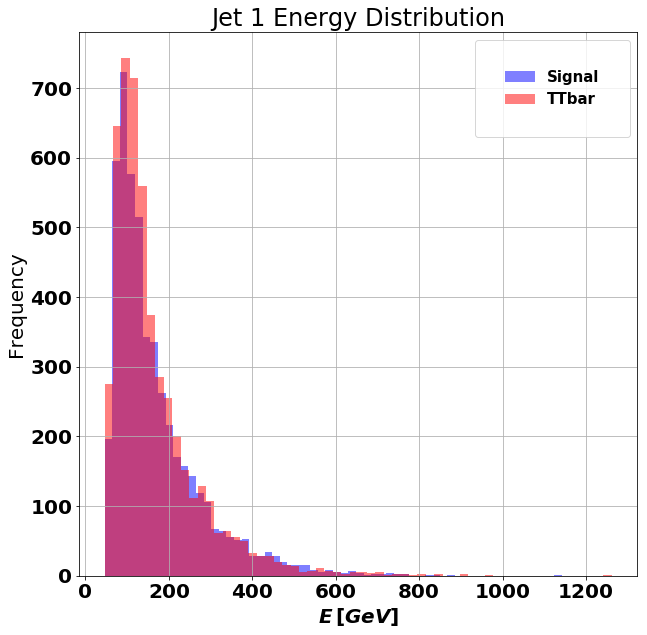

In [37]:

plt.rc('legend', **{'fontsize':15})
plt.rc('font', weight='bold', size=20)
plt.figure(figsize=(10,10))
plt.hist(signal[:,10],60,color='b',label='Signal',alpha=0.5)
plt.hist(ttbar[:,10],60,color='r',label='TTbar',alpha=0.5)
plt.grid()
plt.title('Jet 1 Energy Distribution')
plt.xlabel(r'$E \,[GeV]$')
plt.ylabel('Frequency')
plt.legend(borderpad=2)
plt.savefig(path_tosave+'/'+'plot_Energy.pdf')
plt.show()


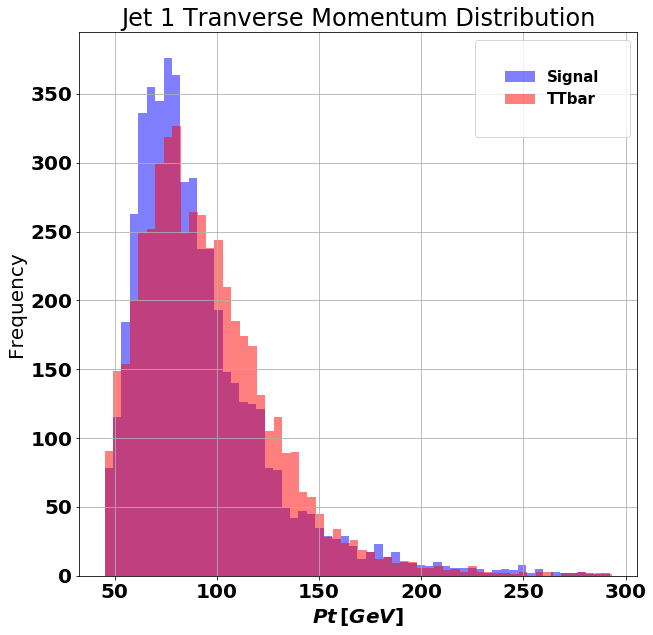

In [38]:
plt.rc('legend', **{'fontsize':15})
plt.rc('font', weight='bold', size=20)
plt.figure(figsize=(10,10))
plt.hist(signal[:,7],60,color='b',label='Signal',alpha=0.5)
plt.hist(ttbar[:,7],60,color='r',label='TTbar',alpha=0.5)
plt.grid()
plt.title('Jet 1 Tranverse Momentum Distribution')
plt.xlabel(r'$Pt \,[GeV]$')
plt.ylabel('Frequency')
plt.legend(borderpad=2)
plt.savefig(path_tosave+'/'+'plot_Pt.pdf')
plt.show()


In [56]:
from sklearn.cluster import KMeans
n_folds = 10
n_clusters = 12

CVO = cross_validation.StratifiedKFold(trgt,n_folds)
CVO = list(CVO)

F_in_signal = np.zeros([n_folds,len(range(2,n_clusters))])
F_in_ttbar = np.zeros([n_folds,len(range(2,n_clusters))])
sil_signal = np.zeros([n_folds,len(range(2,n_clusters))])
sil_ttbar = np.zeros([n_folds,len(range(2,n_clusters))])


for icluster in range(2,n_clusters):    
    print '===================',icluster,'=========================='
    for ifold in range(n_folds):
        train_id, test_id = CVO[ifold]
        #print data[trgt[train_id]==1]
        scale_signal = preprocessing.StandardScaler().fit(data[train_id][trgt[train_id]==1])
        scale_ttbar = preprocessing.StandardScaler().fit(data[train_id][trgt[train_id]==0])

        norm_factor = np.zeros_like(scale_signal.scale_)
        norm_factor = np.transpose(norm_factor)
        for i in range(norm_factor.shape[0]):
            norm_factor[i] = min(scale_signal.scale_[i],scale_ttbar.scale_[i])

        norm_data = preprocessing.scale(data,with_std=False)

        for i in range(norm_data.shape[1]):
            norm_data[:,i] = (1/norm_factor[i])*norm_data[:,i]


        for i in range(norm_data.shape[1]):
            norm_data[:,i] = (1/norm_factor[i])*norm_data[:,i]
        kmeans_signal = KMeans(n_clusters=icluster, random_state=0).fit(norm_data[train_id][trgt[train_id]==1])
        kmeans_ttbar = KMeans(n_clusters=icluster, random_state=0).fit(norm_data[train_id][trgt[train_id]==0])
    
        output_kmeans_signal = kmeans_signal.predict(norm_data)
        
        output_kmeans_ttbar = kmeans_ttbar.predict(norm_data)
        #print output_kmeans_signal[trgt==1].shape
        #print norm_data[output_kmeans_signal[test_id][trgt[test_id]==1]]
    
        cluster_list_signal = []
        for i in range(len(np.unique(output_kmeans_signal[test_id][trgt[test_id]==1]))):
            cluster_list_signal.append(norm_data[output_kmeans_signal[test_id][trgt[test_id]==1]==i])
        #print 'elementos na lista sinal',len(cluster_list_signal)
        print output_kmeans_ttbar[test_id][trgt[test_id]==0].shape
        cluster_list_ttbar = []
        for j in range(len(np.unique(output_kmeans_ttbar[test_id][trgt[test_id]==0]))):
            cluster_list_ttbar.append(norm_data[output_kmeans_ttbar[test_id][trgt[test_id]==0]==j])
            
        #print 'elementos na lista ttbar',len(cluster_list_ttbar)
        sil_signal[ifold,icluster-2] = metrics.silhouette_score(norm_data[test_id][trgt[test_id]==1],
                                                                output_kmeans_signal[test_id][trgt[test_id]==1])
        sil_ttbar[ifold,icluster-2] = metrics.silhouette_score(norm_data[test_id][trgt[test_id]==0],
                                                               output_kmeans_ttbar[test_id][trgt[test_id]==0])
        F_in_signal[ifold,icluster-2] = ClusterMerits.DispIntraClass(cluster_list_signal)
        F_in_ttbar[ifold,icluster-2] = ClusterMerits.DispIntraClass(cluster_list_ttbar)
        a =norm_data[test_id][trgt[test_id]==1]
        print '====================',icluster,'======================='
        print 'F_0 sinal', ClusterMerits.DispTotal(a,media='')
        print 'F_in + F_out', ClusterMerits.DispIntraClass(cluster_list_signal) + ClusterMerits.DispInterClass(cluster_list_signal,a)
        print 'F_0 - F_in + F_out', ClusterMerits.DispTotal(a,media='')- (ClusterMerits.DispIntraClass(cluster_list_signal) + ClusterMerits.DispInterClass(cluster_list_signal,a))
        print '========================================================='
    #print 'silhueta',metrics.silhouette_score(norm_signal[train_id],kmeans_output[train_id])
    #print '========================================='

print 'Done!'

=================== 2 ==========================


IndexError: index 5000 is out of bounds for axis 1 with size 5000

In [57]:
len(np.unique(trgt))

2

In [51]:
a = np.random.randint(5, size=(5, 5))
print 'a=',a
a_t = (np.ones(a.shape[0])).astype(int)
b = np.random.randint(5, size=(5, 5))
print 'b=',b
b_t = (np.zeros(b.shape[0])).astype(int)
c = np.append(a,b,axis=0)
c_t = np.append(a_t,b_t,axis=0)
print c.shape

a= [[1 4 3 3 4]
 [0 1 1 4 4]
 [3 1 0 4 0]
 [1 0 0 4 2]
 [4 2 2 3 3]]
b= [[1 3 4 1 0]
 [2 2 0 1 3]
 [1 4 4 4 3]
 [4 1 2 2 2]
 [0 1 3 4 1]]
(10, 5)


In [54]:

n_folds =5
CVO = cross_validation.StratifiedKFold(c_t,n_folds)
CVO = list(CVO)
#print CVO
for ifold in range(n_folds):
    train_id, test_id = CVO[ifold]
    print 'train set',c[train_id][c_t[train_id]==1]
    km1 = KMeans(n_clusters=2,random_state=0).fit(c[train_id][c_t[train_id]==1])
    out = km1.predict(c)
    print test_id
    print 'test set', c[out[test_id]]
    print 'out', out
    print 'out para a', c[out[c_t[test_id]==0]]
    print 'out teste set ',
    #print 'out teste set so que ta a',c[out[test_id]][c_t[test_id]==c_t[test_id]]
    print '======================================================'

train set [[0 1 1 4 4]
 [3 1 0 4 0]
 [1 0 0 4 2]
 [4 2 2 3 3]]
[0 5]
test set [[1 4 3 3 4]
 [0 1 1 4 4]]
out [0 0 1 0 1 1 1 1 1 0]
out para a [[1 4 3 3 4]]
out teste set  ======================================================
train set [[1 4 3 3 4]
 [3 1 0 4 0]
 [1 0 0 4 2]
 [4 2 2 3 3]]
[1 6]
test set [[1 4 3 3 4]
 [1 4 3 3 4]]
out [0 0 1 1 0 0 0 0 0 1]
out para a [[1 4 3 3 4]]
out teste set  ======================================================
train set [[1 4 3 3 4]
 [0 1 1 4 4]
 [1 0 0 4 2]
 [4 2 2 3 3]]
[2 7]
test set [[0 1 1 4 4]
 [1 4 3 3 4]]
out [0 1 1 1 0 0 0 0 0 1]
out para a [[0 1 1 4 4]]
out teste set  ======================================================
train set [[1 4 3 3 4]
 [0 1 1 4 4]
 [3 1 0 4 0]
 [4 2 2 3 3]]
[3 8]
test set [[0 1 1 4 4]
 [0 1 1 4 4]]
out [0 0 1 1 1 1 1 0 1 0]
out para a [[1 4 3 3 4]]
out teste set  ======================================================
train set [[1 4 3 3 4]
 [0 1 1 4 4]
 [3 1 0 4 0]
 [1 0 0 4 2]]
[4 9]
test set [[1 4 3 3 4]
 [1 4

/home/micael/.virtualenvs/MyAnalysis/lib/python2.7/site-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 10 but corresponding boolean dimension is 2
  


In [50]:
mean_sil_signal = np.zeros([sil_signal.shape[1],])
sigma_sil_signal = np.zeros([sil_signal.shape[1],])

for i in range(mean_sil_signal.shape[0]):
    mean_sil_signal[i] = np.mean(sil_signal[:,i])
    sigma_sil_signal[i] = np.sqrt(np.var(sil_signal[:,i]))

mean_sil_ttbar = np.zeros([sil_ttbar.shape[1],])
sigma_sil_ttbar = np.zeros([sil_ttbar.shape[1],])

for i in range(mean_sil_ttbar.shape[0]):
    mean_sil_ttbar[i] = np.mean(sil_ttbar[:,i])
    sigma_sil_ttbar[i] = np.sqrt(np.var(sil_ttbar[:,i]))
    
mean_Fin_signal = np.zeros([F_in_signal.shape[1],])
sigma_Fin_signal = np.zeros([F_in_signal.shape[1],])

for i in range(mean_Fin_signal.shape[0]):
    mean_Fin_signal[i] = np.mean(F_in_signal[:,i])
    sigma_Fin_signal[i] = np.sqrt(np.var(F_in_signal[:,i]))

mean_Fin_ttbar = np.zeros([F_in_ttbar.shape[1],])
sigma_Fin_ttbar = np.zeros([F_in_ttbar.shape[1],])

for i in range(mean_Fin_ttbar.shape[0]):
    mean_Fin_ttbar[i] = np.mean(F_in_ttbar[:,i])
    sigma_Fin_ttbar[i] = np.sqrt(np.var(F_in_ttbar[:,i]))
x = np.array([2,3,4,5,6,7,8,9,10,11])

In [60]:
F_in_signal[:,0]

array([ 109353.41039367,  109757.58164127,  109476.0376375 ,
        109592.42105902,  109579.61227265,  109982.873154  ,
        110069.68590401,  109474.62405193,  109868.74392738,
        109790.24985706])

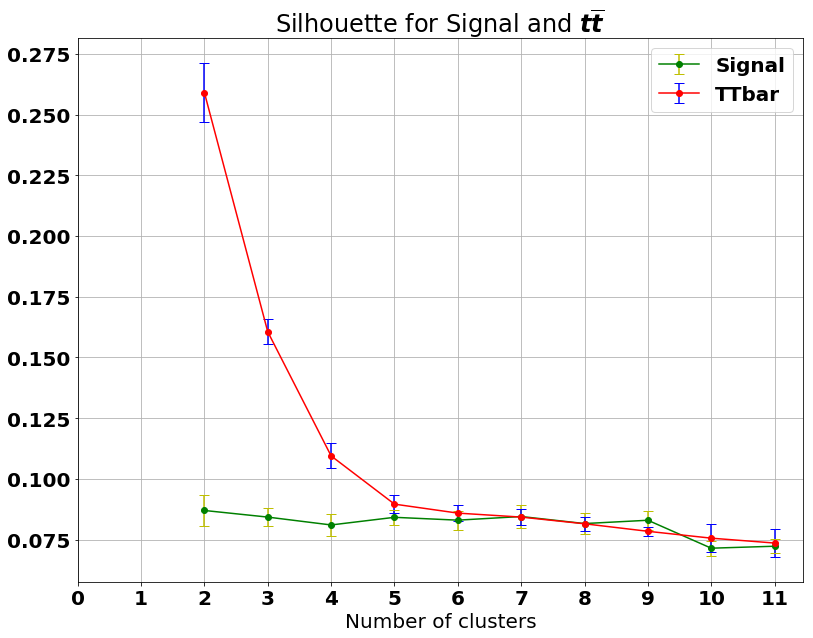

In [13]:
plt.rc('font', weight='bold', size=20)
plt.figure(figsize=(13,10))
plt.errorbar(x,mean_sil_signal,yerr=sigma_sil_signal,color='g',ecolor='y',fmt='-o',capsize=5,label='Signal')
plt.errorbar(x,mean_sil_ttbar,yerr=sigma_sil_ttbar,color='r',ecolor='b',fmt='-o',capsize=5,label='TTbar')
plt.title(r'Silhouette for Signal and $t\overline{t}$')
plt.xlabel('Number of clusters')
plt.legend()
plt.xticks(np.arange(min(x)-2, max(x)+1))
#plt.ylabel()
plt.grid()
plt.savefig(path_tosave+'/'+'SilhuetteSignalTTbar_v3.pdf')

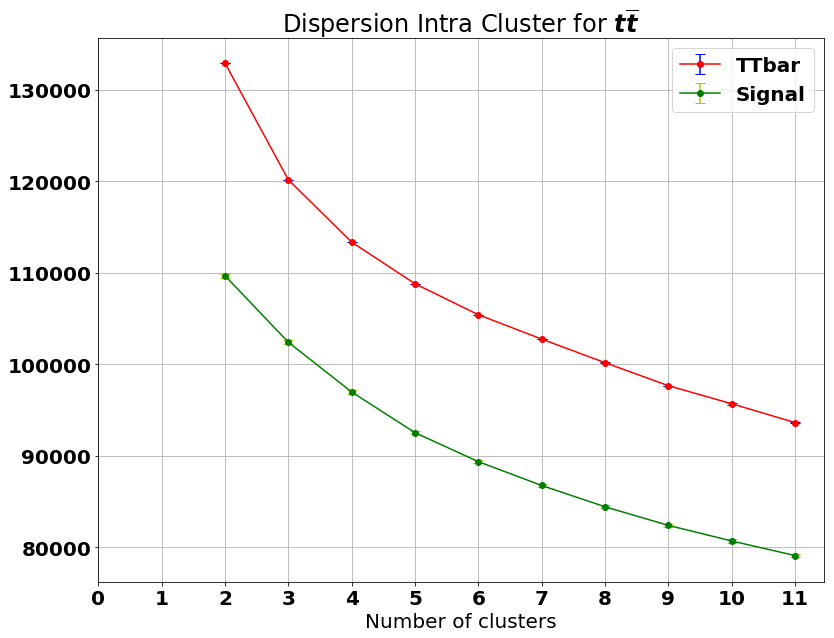

In [14]:
plt.rc('font', weight='bold', size=20)
plt.figure(figsize=(13,10))
plt.errorbar(x,mean_Fin_ttbar,yerr=sigma_Fin_ttbar,color='r',ecolor='b',fmt='-o',capsize=5,label='TTbar')
plt.errorbar(x,mean_Fin_signal,yerr=sigma_Fin_signal,color='g',ecolor='y',fmt='-o',capsize=5,label='Signal')
plt.title(r'Dispersion Intra Cluster for $t\overline{t}$')
plt.xlabel('Number of clusters')
plt.xticks(np.arange(min(x)-2, max(x)+1))
plt.legend()
#plt.ylabel()
plt.grid()
#plt.savefig(path_tosave+'/'+'F_inTTBAR.pdf')

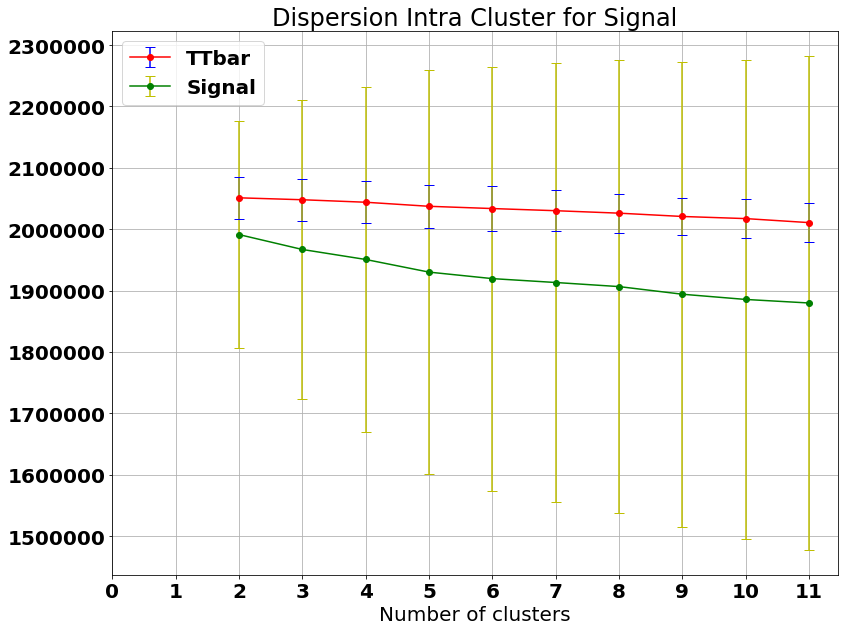

In [53]:
plt.rc('font', weight='bold', size=20)
plt.figure(figsize=(13,10))
plt.errorbar(x,mean_Fin_ttbar,yerr=sigma_Fin_ttbar,color='r',ecolor='b',fmt='-o',capsize=5,label='TTbar')
plt.errorbar(x,mean_Fin_signal,yerr=sigma_Fin_signal,color='g',ecolor='y',fmt='-o',capsize=5,label='Signal')
plt.title(r'Dispersion Intra Cluster for Signal')
plt.xlabel('Number of clusters')
plt.xticks(np.arange(min(x)-2, max(x)+1))
plt.legend()
#plt.ylabel()
plt.grid()
plt.savefig(path_tosave+'/'+'F_inSIGNALTTBAR.pdf')

('For n_clusters =', 2, 'The average silhouette_score is :', 0.38497377115810927)


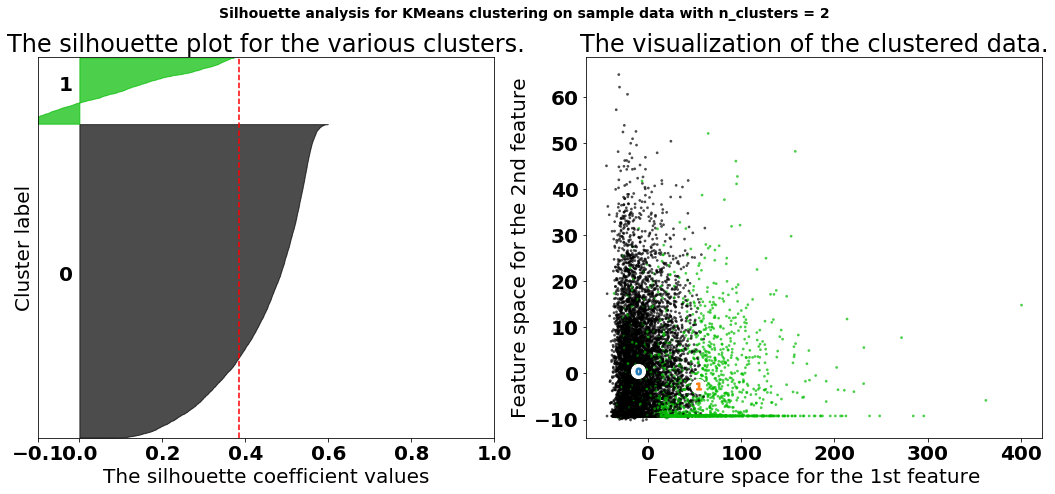

('For n_clusters =', 3, 'The average silhouette_score is :', 0.29096064717725079)


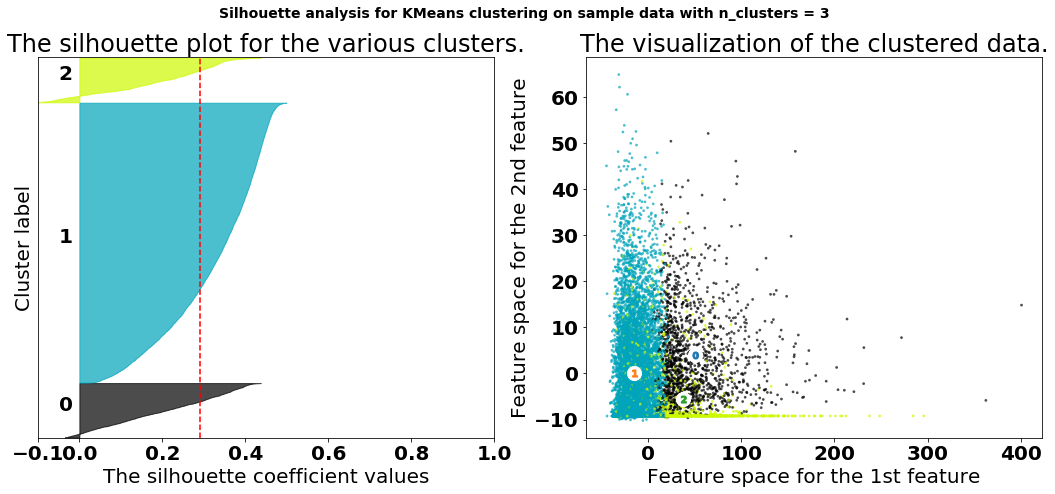

('For n_clusters =', 4, 'The average silhouette_score is :', 0.20636261869307915)


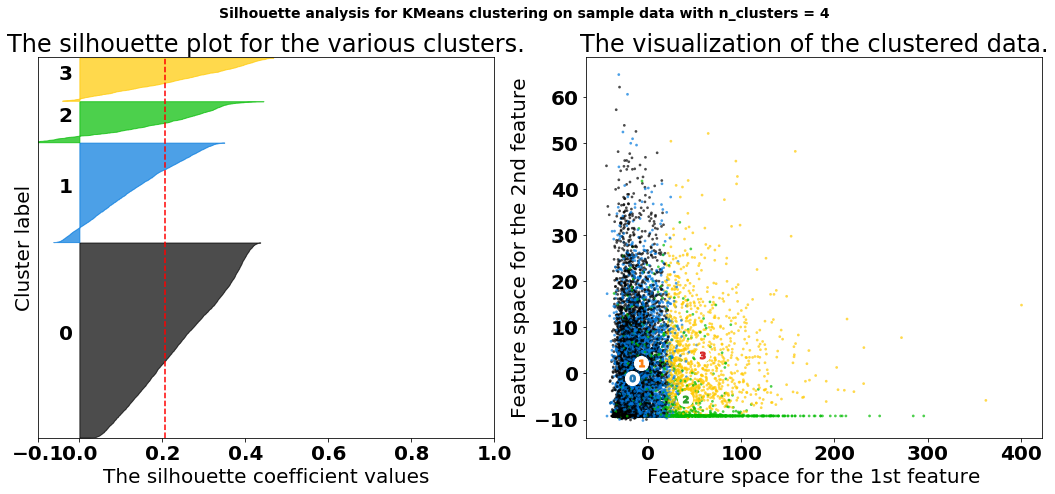

('For n_clusters =', 5, 'The average silhouette_score is :', 0.2145394525355549)


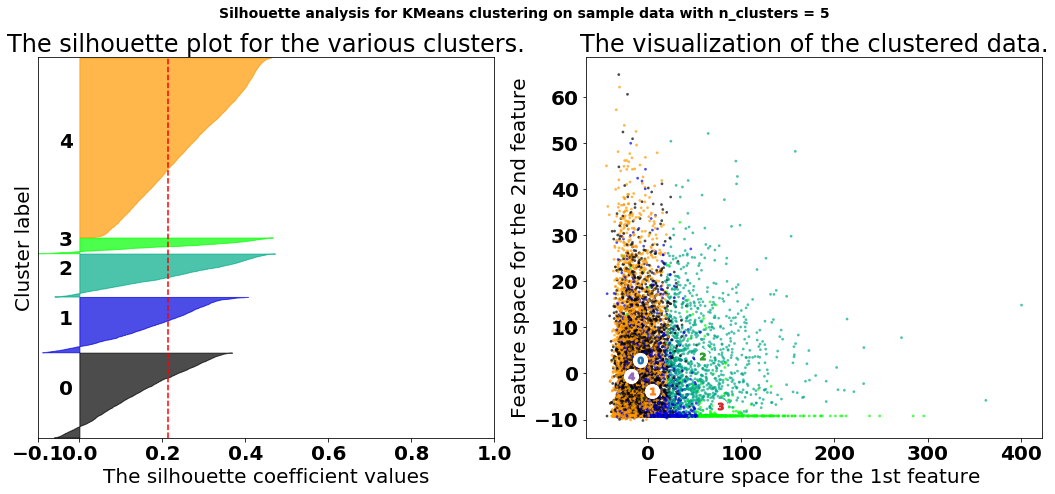

('For n_clusters =', 6, 'The average silhouette_score is :', 0.16528192397245889)


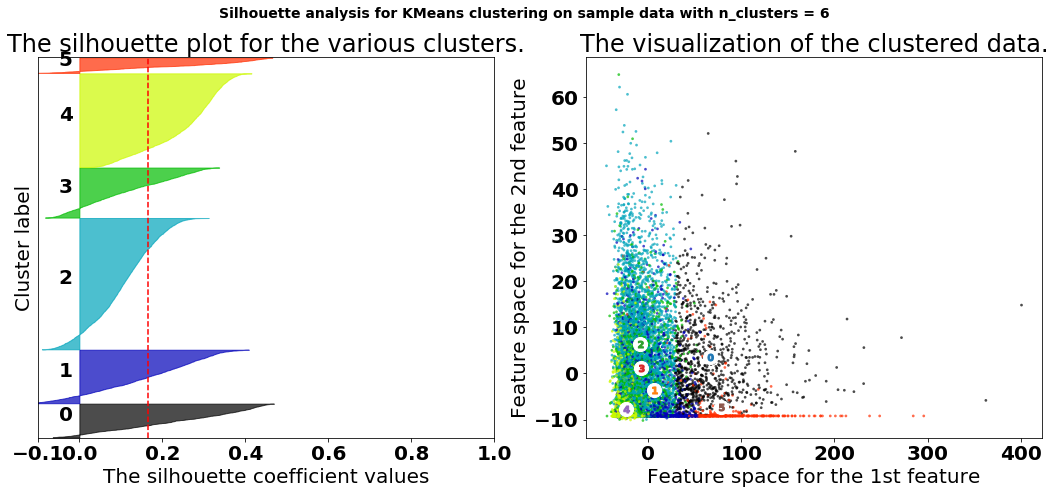

('For n_clusters =', 7, 'The average silhouette_score is :', 0.17013875298467468)


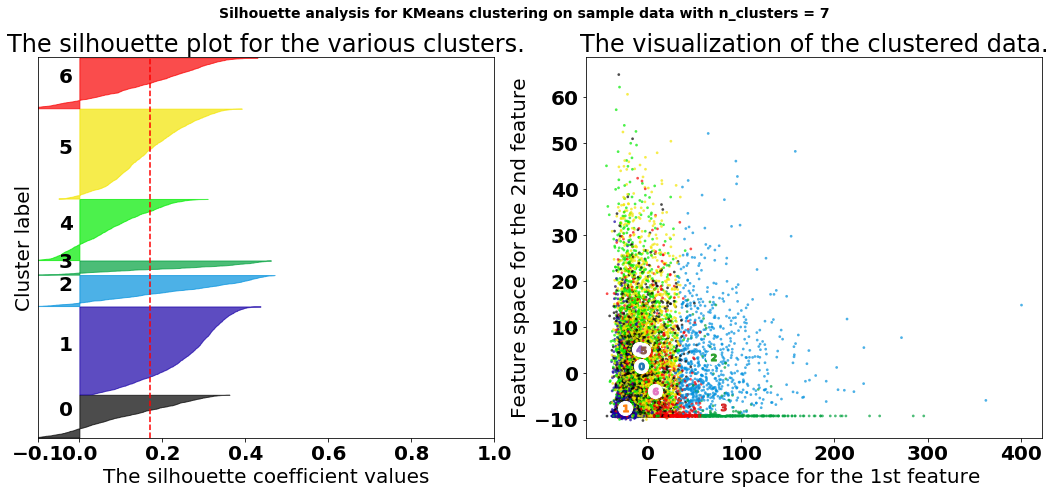

('For n_clusters =', 8, 'The average silhouette_score is :', 0.17341031664222495)


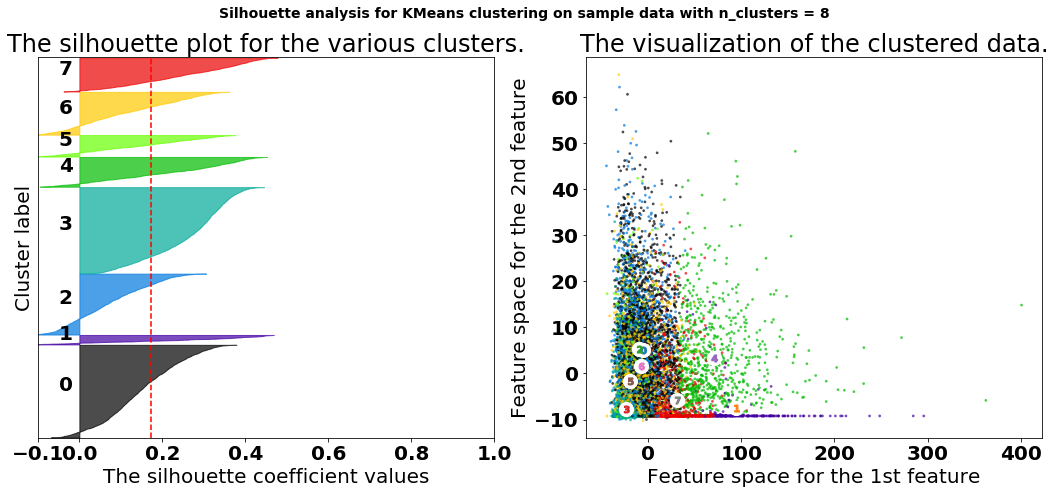

('For n_clusters =', 9, 'The average silhouette_score is :', 0.18122144826097672)


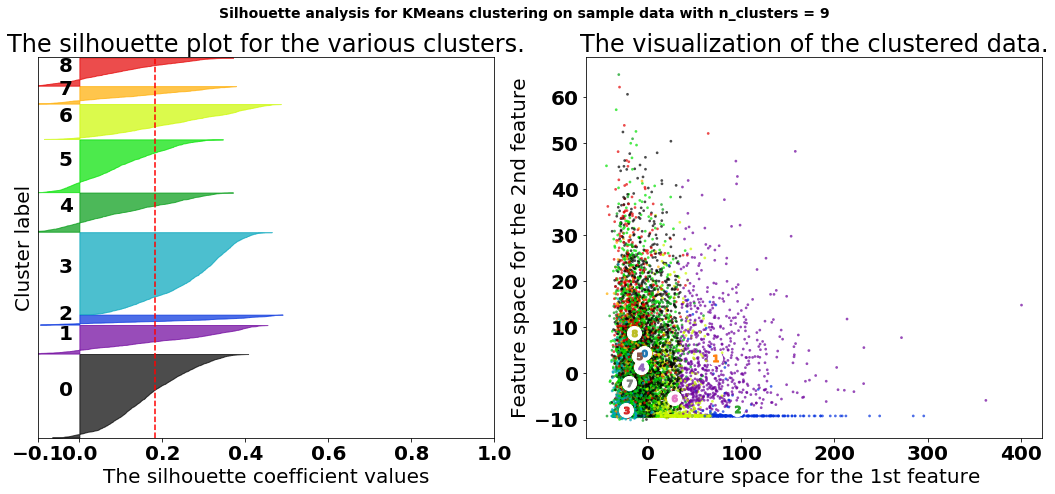

('For n_clusters =', 10, 'The average silhouette_score is :', 0.17855772355528621)


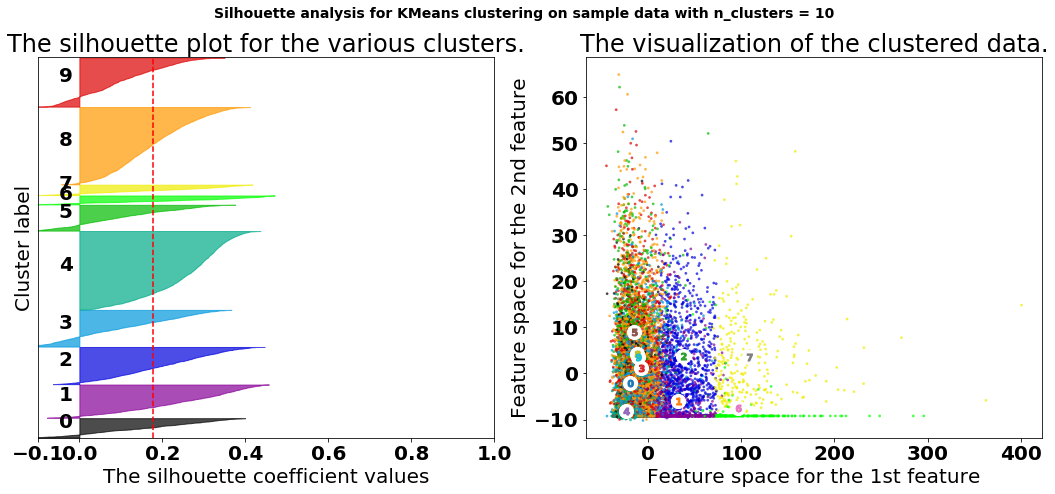

('For n_clusters =', 11, 'The average silhouette_score is :', 0.17698514911048302)


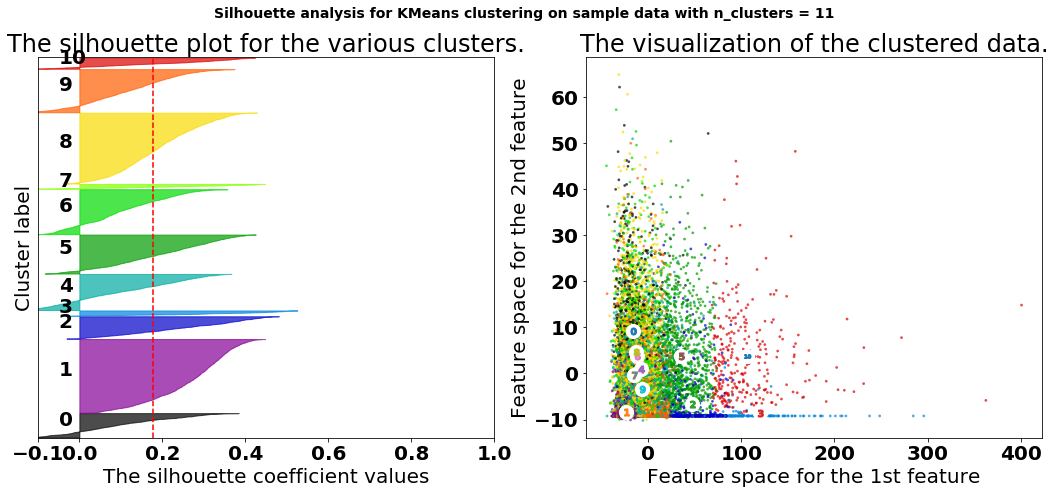

In [28]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

X = norm_data
range_n_clusters = [2, 3, 4, 5, 6,7,8,9,10,11]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()


In [18]:
#plt.rc('font', weight='bold', size=20)
#plt.figure(figsize=(13,10))
#plt.errorbar(x,mean_sil_ttbar,yerr=sigma_sil_ttbar,ecolor='r',fmt='-o',capsize=5)
#plt.title(r'Silhouette for $t\overline{t}$')
#plt.xlabel('Number of clusters')
#plt.xticks(np.arange(min(x)-2, max(x)+1))
#plt.ylabel()
#plt.grid()

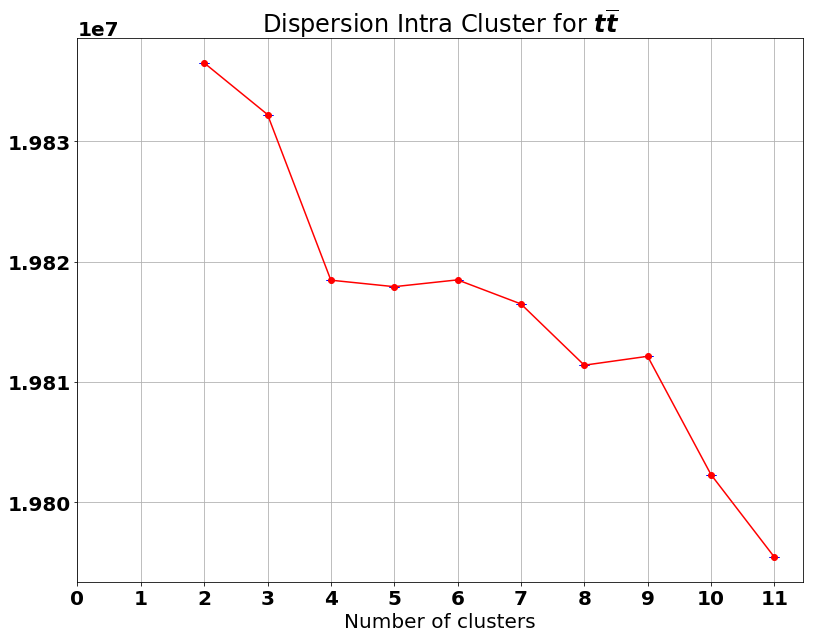

In [17]:
plt.rc('font', weight='bold', size=20)
plt.figure(figsize=(13,10))
plt.errorbar(x,mean_Fin_ttbar,yerr=sigma_Fin_ttbar,color='r',ecolor='b',fmt='-o',capsize=5,label='TTbar')
#plt.errorbar(x,mean_Fin_signal,yerr=sigma_Fin_signal,color='g',ecolor='b',fmt='-o',capsize=5,label='Signal')
plt.title(r'Dispersion Intra Cluster for $t\overline{t}$')
plt.xlabel('Number of clusters')
plt.xticks(np.arange(min(x)-2, max(x)+1))
#plt.ylabel()
plt.grid()

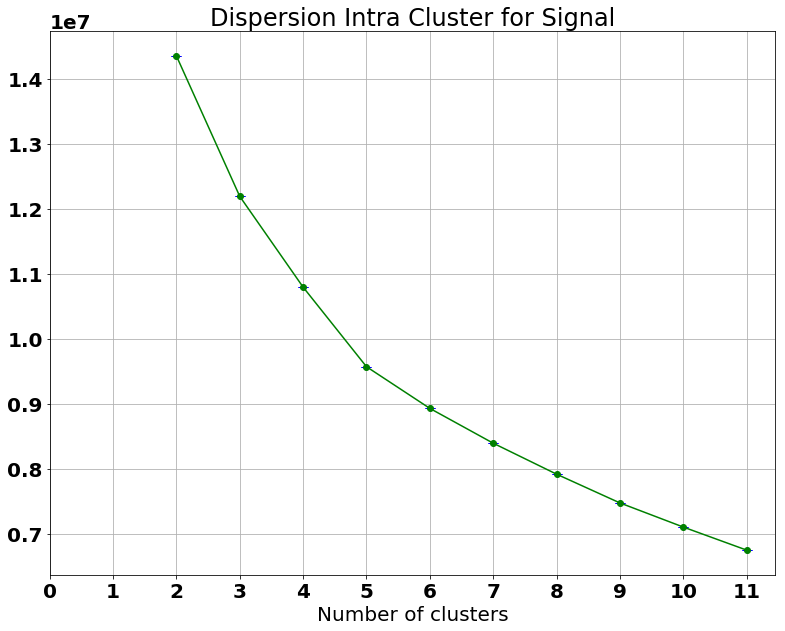

In [16]:
plt.rc('font', weight='bold', size=20)
plt.figure(figsize=(13,10))
plt.errorbar(x,mean_Fin_signal,yerr=sigma_Fin_signal,color='g',ecolor='b',fmt='-o',capsize=5)
plt.title(r'Dispersion Intra Cluster for Signal')
plt.xlabel('Number of clusters')
plt.xticks(np.arange(min(x)-2, max(x)+1))
#plt.ylabel()
plt.grid()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.01 µs


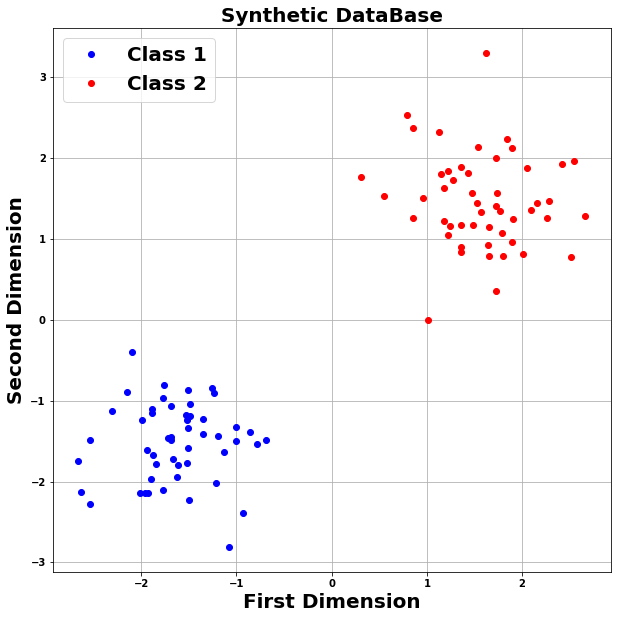

In [29]:
m_font_size = 20
%time
# Create Data
n_events = 50

# dados em 45^o
angle = np.pi/2
rotation_matrix = [[np.cos(angle), -np.sin(angle)],[np.sin(angle), np.cos(angle)]]

m_means = [-1.5,1.5]
m_vars = [0.1,0.1]

data_c1 = m_vars*np.random.randn(n_events,2)+m_means
data_c1 = np.inner(data_c1,rotation_matrix)

m_means = [1.5,-1.5]
m_vars = [0.1,0.1]

data_c2 = m_vars*np.random.randn(n_events,2)+m_means
data_c2 = np.inner(data_c2,rotation_matrix)

data_jr = np.append(data_c1, data_c2,axis=0)
trgt_jr = np.append(np.zeros(data_c1.shape[0]),np.ones(data_c2.shape[0]),axis=0)

# plot data
%matplotlib inline  

fig = plt.figure(figsize=(10,10))

plt.plot(data[trgt==0,0],data[trgt==0,1],'bo',label='Class 1')
plt.plot(data[trgt==1,0],data[trgt==1,1],'ro',label='Class 2')

plt.legend(fontsize=m_font_size)
plt.grid()
plt.title('Synthetic DataBase',fontweight='bold',fontsize=m_font_size)
plt.xlabel('First Dimension',fontweight='bold',fontsize=m_font_size)
plt.ylabel('Second Dimension',fontweight='bold',fontsize=m_font_size)
#limits = [-5, 5]
#plt.xlim(limits)
#plt.ylim(limits)

In [30]:
metrics.silhouette_score(data_jr,trgt_jr)

0.95962579449346197

In [4]:
# this cell normalize the data Caloba ways
norm_data = np.zeros_like(data)

scale_signal = preprocessing.StandardScaler().fit(data[trgt==1])
scale_ttbar = preprocessing.StandardScaler().fit(data[trgt==0])

norm_factor = np.zeros_like(scale_signal.scale_)
norm_factor = np.transpose(norm_factor)
for i in range(norm_factor.shape[0]):
    norm_factor[i] = min(scale_signal.scale_[i],scale_ttbar.scale_[i])

norm_data = preprocessing.scale(data,with_std=False)

for i in range(data.shape[1]):
    norm_data[:,i] = (1/norm_factor[i])*data[:,i]


norm_data = preprocessing.scale(data,with_std=False)

for i in range(norm_data.shape[1]):
    norm_data[:,i] = (1/norm_factor[i])*norm_data[:,i]
print np.mean(norm_data),np.std(norm_data[:,3])

9.07556857948e-18 1.00403889935


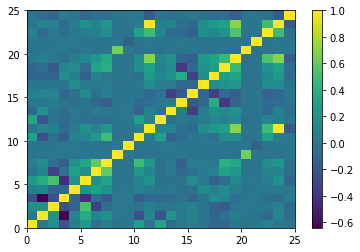

In [8]:
from pylab import pcolor, show, colorbar, xticks, yticks

R = np.corrcoef(data_trgt,rowvar=0)
pcolor(R)
colorbar()
#yticks(arange(0.5,10.5),range(0,10))
#xticks(arange(0.5,10.5),range(0,10))
show()

/home/micael/.virtualenvs/MyAnalysis/lib/python2.7/site-packages/ipykernel_launcher.py:38: UserWarning: Warning: converting a masked element to nan.


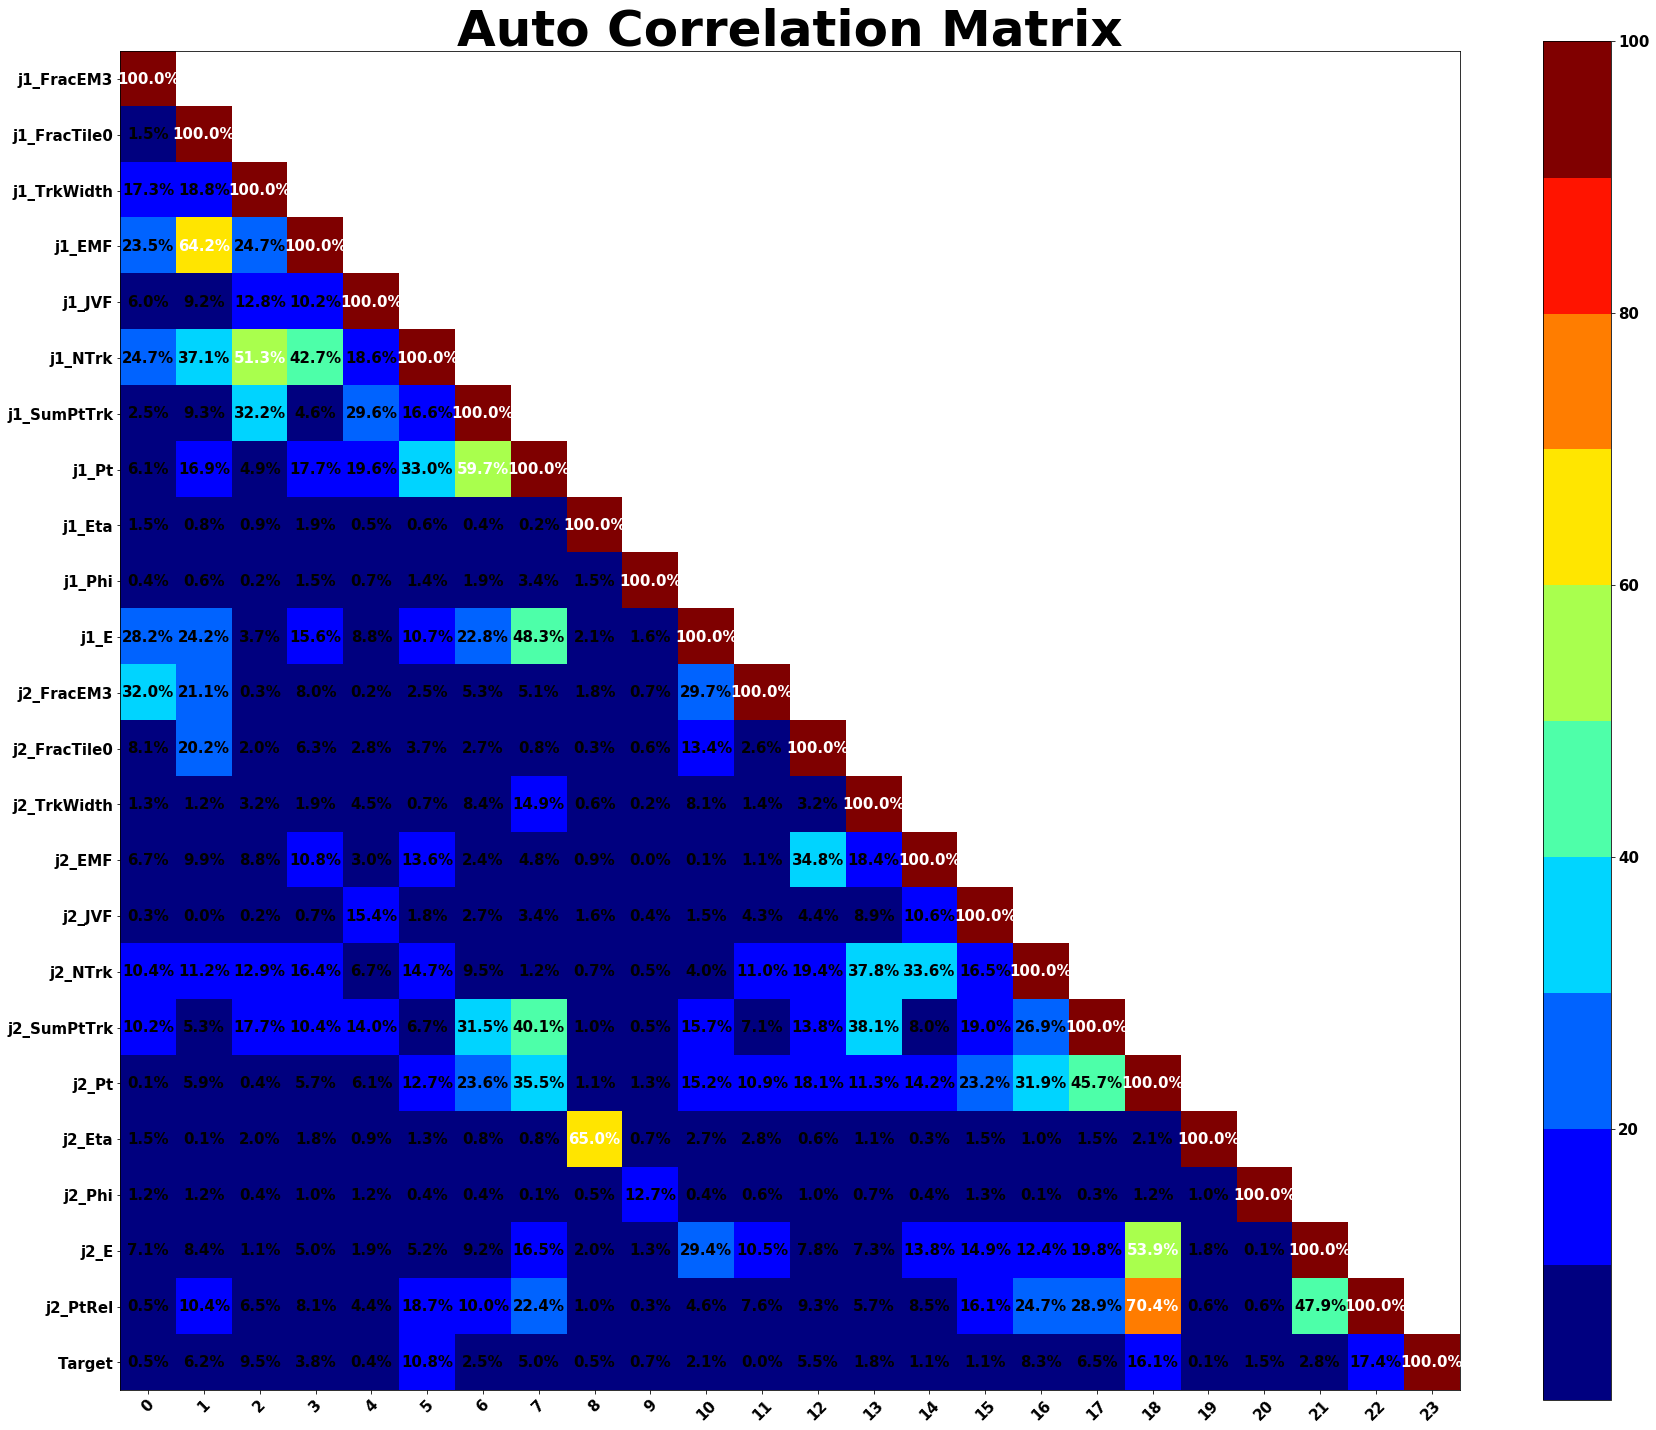

In [69]:
# Make a correlation matrix between variabels and target.

import matplotlib.pyplot as plt
from matplotlib import cm as CM
%matplotlib inline 

#plt.rcParams['xtick.labelsize'] = 30
#plt.rcParams['ytick.labelsize'] = 30

#plt.rc('legend', **{'fontsize':15})

plt.rc('font', weight='bold', size=15)

AutCor = abs(100.0*np.corrcoef(data_trgt,rowvar=0))
mask =  np.triu(AutCor, k=1)
AutCor = np.ma.array(AutCor, mask=mask)

fig = plt.figure(figsize=(30,25))
ax = fig.add_subplot(111)
#ax.set_aspect(1)
#cm = cm.astype('float')/ cm.sum(axis=1)[:, np.newaxis]

cmap = CM.get_cmap('jet', 10)
cmap.set_bad('w')
AutoCor_Matrix = ax.imshow(AutCor,interpolation="nearest", cmap=cmap)
#mask =  np.tri(data_trgt.shape[0], k=-1)


fig.colorbar(AutoCor_Matrix)

width, height = AutCor.shape

for x in xrange(width):
    for y in xrange(height):
        if AutCor[x][y] < 50.:
            ax.annotate("%1.1f%%"%(AutCor[x][y]), xy=(y, x), horizontalalignment="center",verticalalignment="center")
        else:
            ax.annotate("%1.1f%%"%(AutCor[x][y]), xy=(y, x), horizontalalignment="center",verticalalignment="center",color="white")

ax.set_yticks(np.arange(AutCor.shape[1]))
ax.set_xticks(np.arange(AutCor.shape[0]))

labels = ['j1_FracEM3', 'j1_FracTile0', 'j1_TrkWidth', 'j1_EMF', 'j1_JVF', 'j1_NTrk', 'j1_SumPtTrk', 'j1_Pt', 'j1_Eta', 'j1_Phi', 'j1_E', 'j2_FracEM3', 'j2_FracTile0', 'j2_TrkWidth', 'j2_EMF', 'j2_JVF', 'j2_NTrk', 'j2_SumPtTrk', 'j2_Pt', 'j2_Eta', 'j2_Phi', 'j2_E', 'j2_PtRel','Target']

#ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

plt.xticks(rotation=45)

ax.set_title('Auto Correlation Matrix', fontweight='bold', fontsize=50)
#plt.savefig(path_tosave+'/'+'AutCorMatrixTRGT.pdf')

In [13]:
data_cut = data_trgt[:,[1,2,3,5,6,7,10,11,13,14,15,16,17,18,19,21,22,24]]

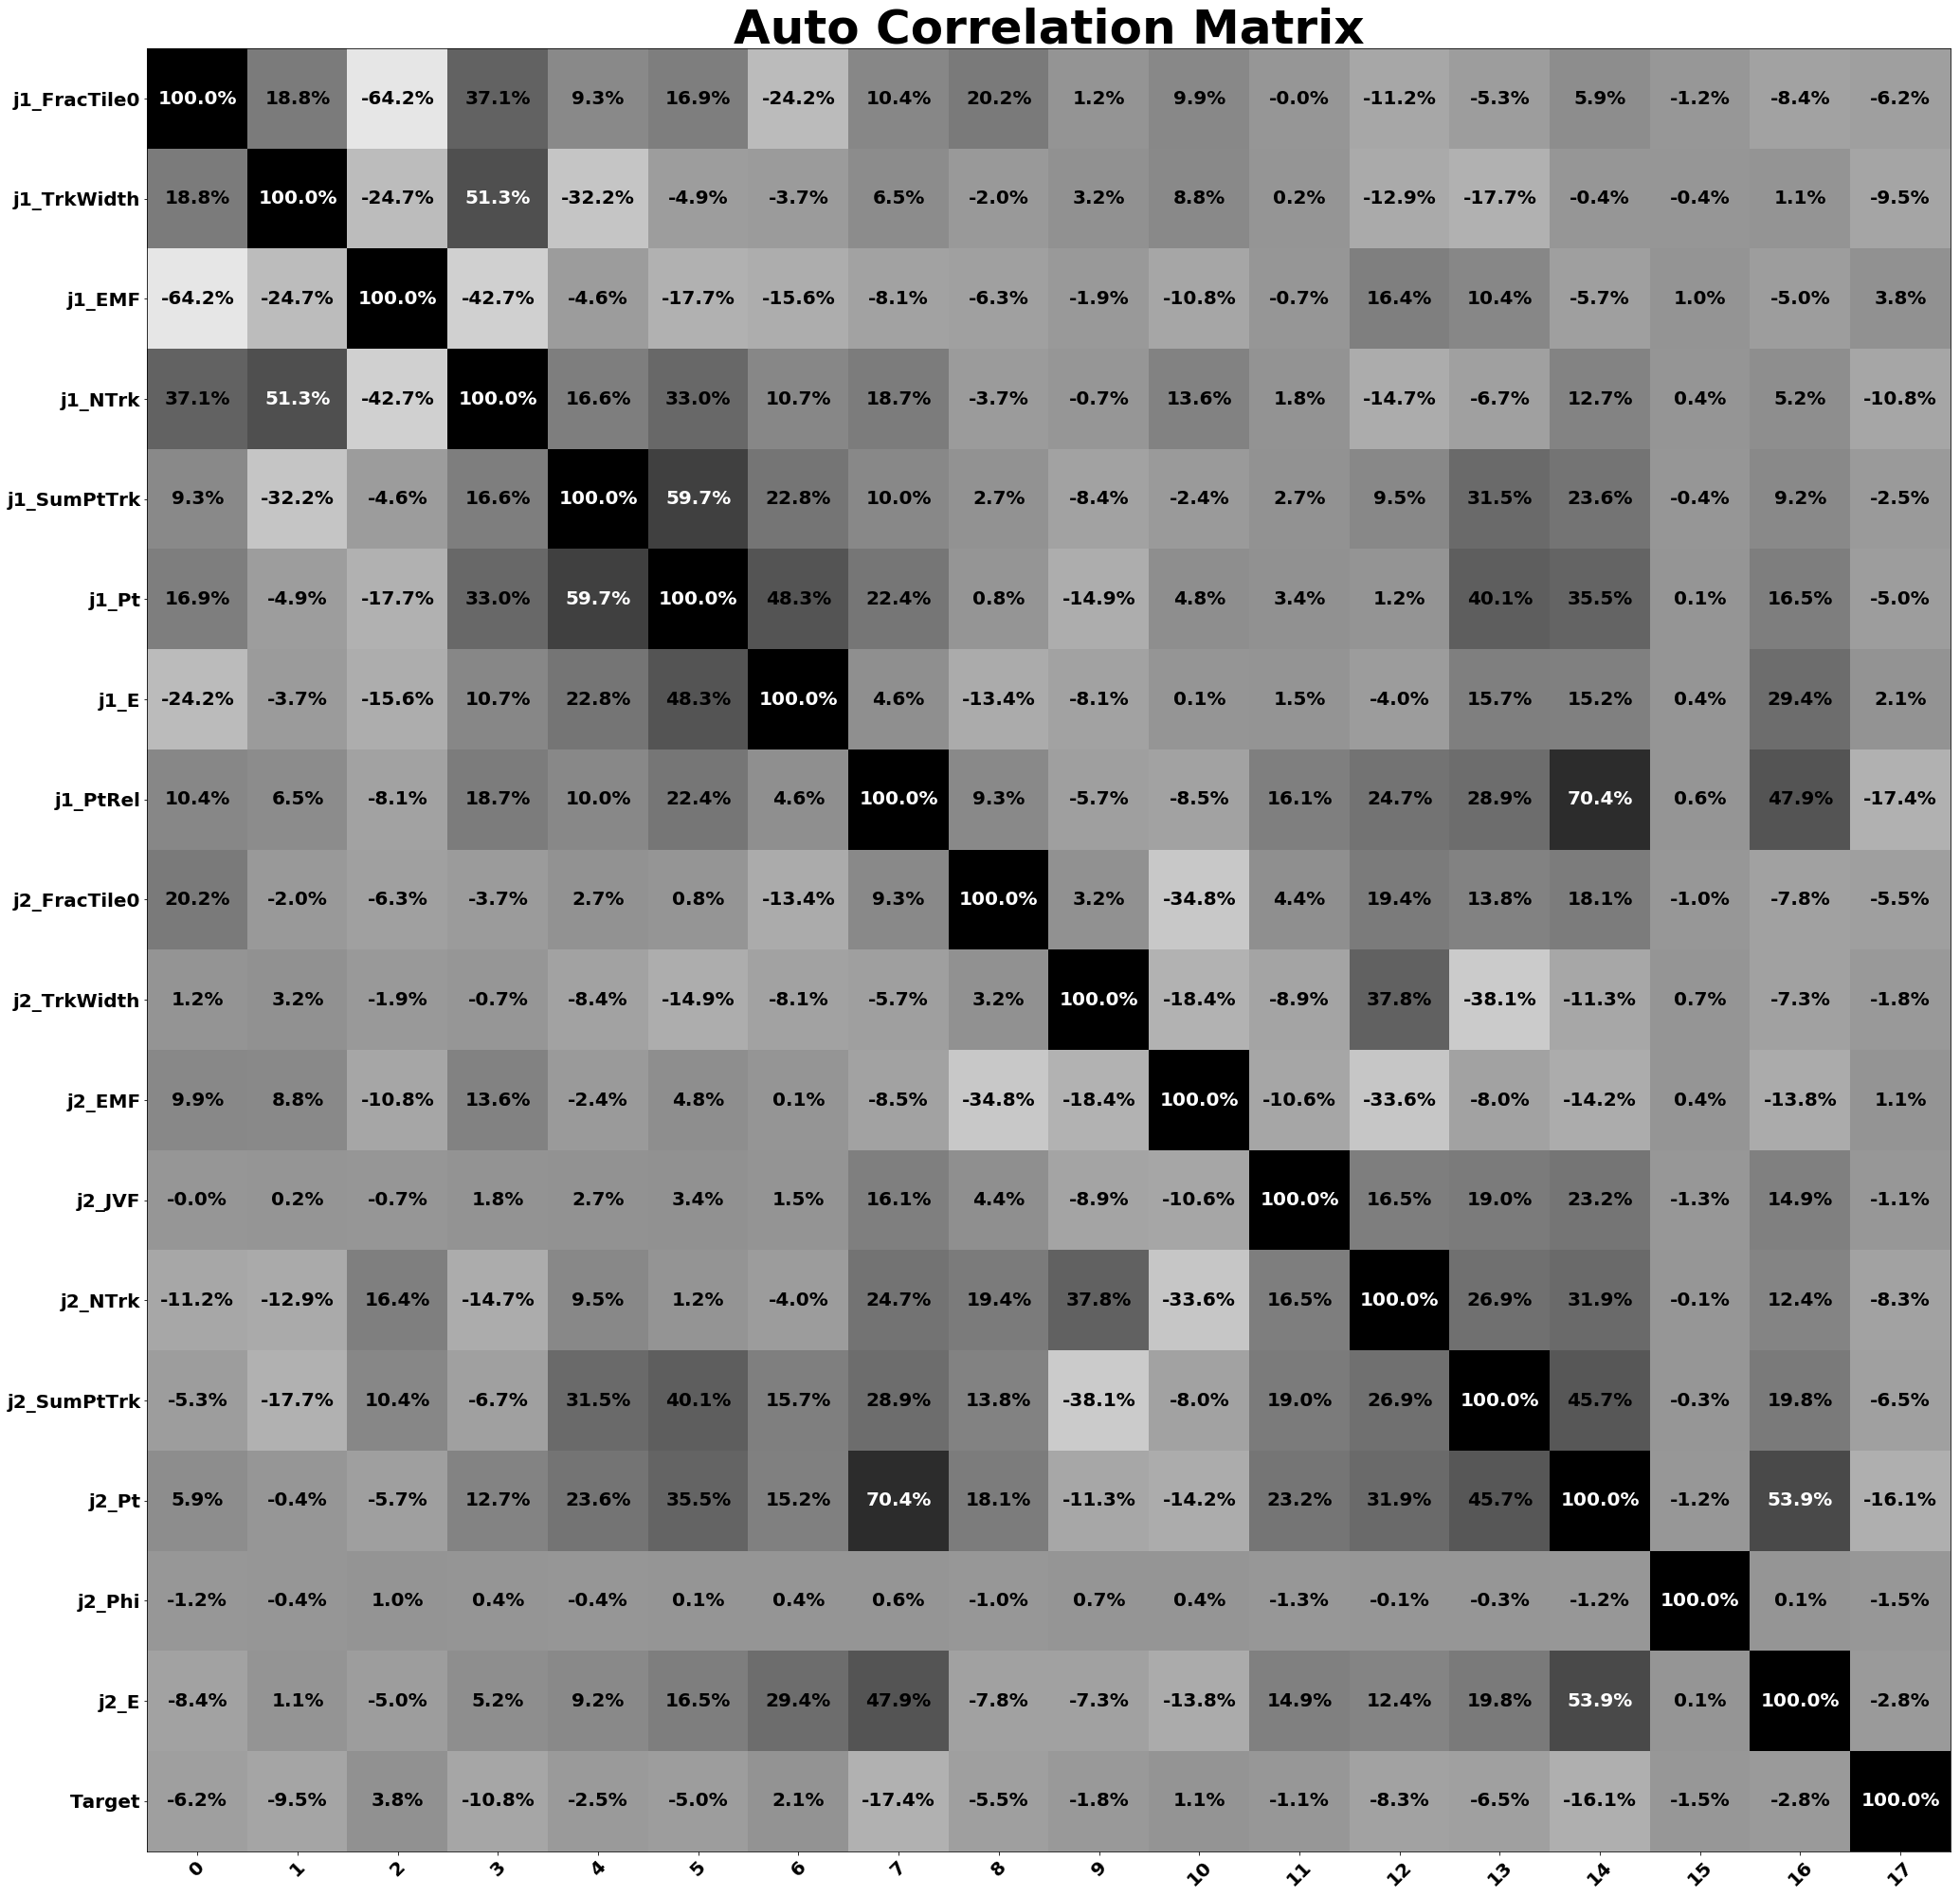

In [14]:
# Make a correlation matrix between variabels and target.

import matplotlib.pyplot as plt
%matplotlib inline 

#plt.rcParams['xtick.labelsize'] = 30
#plt.rcParams['ytick.labelsize'] = 30

plt.rc('legend', **{'fontsize':15})

plt.rc('font', weight='bold', size=20)

AutCor = 100.0*np.corrcoef(data_cut,rowvar=0)

fig = plt.figure(figsize=(35,35))
ax = fig.add_subplot(111)
ax.set_aspect(1)
#cm = cm.astype('float')/ cm.sum(axis=1)[:, np.newaxis]

AutoCor_Matrix = ax.imshow(AutCor,interpolation='nearest',cmap=plt.cm.Greys,clim=(-100.0, 100.0))

#fig.colorbar(AutoCor_Matrix)

width, height = AutCor.shape

for x in xrange(width):
    for y in xrange(height):
        if AutCor[x][y] < 50.:
            ax.annotate("%1.1f%%"%(AutCor[x][y]), xy=(y, x), horizontalalignment="center",verticalalignment="center")
        else:
            ax.annotate("%1.1f%%"%(AutCor[x][y]), xy=(y, x), horizontalalignment="center",verticalalignment="center",color="white")

ax.set_yticks(np.arange(AutCor.shape[1]))
ax.set_xticks(np.arange(AutCor.shape[0]))

labels = ['j1_FracTile0', 'j1_TrkWidth', 'j1_EMF', 'j1_NTrk', 'j1_SumPtTrk', 'j1_Pt', 'j1_E', 'j1_PtRel', 'j2_FracTile0', 'j2_TrkWidth', 'j2_EMF', 'j2_JVF', 'j2_NTrk', 'j2_SumPtTrk', 'j2_Pt', 'j2_Phi', 'j2_E','Target']

#ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

plt.xticks(rotation=45)

ax.set_title('Auto Correlation Matrix', fontweight='bold', fontsize=50)

## Trainamento Supervisionado nos dados utilizando uma camada simples de Kohonen

In [71]:
from functions import SupervisedKohonen
from sklearn import cross_validation
from sklearn.cluster import KMeans

n_folds = 10
n_clusters = [2,4]
n_inits = 1


#Acc_par = np.zeros([n_folds,len(range(0,n_clusters,2))])
#SP_par = np.zeros([n_folds,len(range(0,n_clusters,2))])
Sil_par = np.zeros([n_folds,len(n_clusters)])

#F_in = np.zeros([n_folds,len(range(0,n_clusters,2))])
#F_out = np.zeros([n_folds,len(range(0,n_clusters,2))])

Acc_final = np.zeros([n_folds,len(n_clusters)])
SP_final = np.zeros([n_folds,len(n_clusters)])
#Sil_final = np.zeros([n_folds,len(range(0,n_clusters,2))])
Acc_score_final = np.zeros([n_folds,len(n_clusters)])

    
print Sil_par.shape,Acc_final.shape,SP_final.shape,Acc_score_final.shape
for icluster in n_clusters:
    print icluster

(10, 2) (10, 2) (10, 2) (10, 2)
2
4


In [74]:
for icluster in n_clusters:
    print '==============================',icluster,'======================================'
    trn_params = SupervisedKohonen.TrainParameters()
    trn_params.learning_rate = 0.01
    knn = SupervisedKohonen.KohonenNN()
 
       
    CVO = cross_validation.StratifiedKFold(trgt,n_folds)
    CVO = list(CVO)
    classifiers = {}
        
    for ifold in range(n_folds):
        train_id, test_id = CVO[ifold]
        for i_init in range(n_inits):
            print ('Processing: Fold %i of %i Init %i of %i'%(ifold+1, n_folds, i_init+1, n_inits))        
                                                                         
        #print data[trgt[train_id]==1]
        scale_signal = preprocessing.StandardScaler().fit(data[train_id][trgt[train_id]==1])
        scale_ttbar = preprocessing.StandardScaler().fit(data[train_id][trgt[train_id]==0])

        norm_factor = np.zeros_like(scale_signal.scale_)
        norm_factor = np.transpose(norm_factor)
        for i in range(norm_factor.shape[0]):
            norm_factor[i] = min(scale_signal.scale_[i],scale_ttbar.scale_[i])

        norm_data = preprocessing.scale(data,with_std=False)

        for i in range(norm_data.shape[1]):
            norm_data[:,i] = (1/norm_factor[i])*norm_data[:,i]


        for i in range(norm_data.shape[1]):
            norm_data[:,i] = (1/norm_factor[i])*norm_data[:,i]

                                                                         
        data_signal = norm_data[trgt==1]
        data_ttbar = norm_data[trgt==0]
        ttbar_n_clusters=icluster
        signal_n_clusters=icluster
        kmeans_signal = KMeans(n_clusters=signal_n_clusters, random_state=0).fit_predict(data_signal)
        kmeans_ttbar = KMeans(n_clusters=ttbar_n_clusters, random_state=0).fit_predict(data_ttbar)
        
        new_trgt = np.append((kmeans_signal+ttbar_n_clusters),kmeans_ttbar)
                                                                         
        knn.fit(norm_data[train_id],new_trgt[train_id],trn_params=trn_params)
        classifiers[ifold] = knn
        knn_output = classifiers[ifold].predict(norm_data)
        if icluster==4:
            Sil_par[ifold,1] = metrics.silhouette_score(norm_data[test_id],knn_output[test_id])
        else:
            Sil_par[ifold,icluster-2] = metrics.silhouette_score(norm_data[test_id],knn_output[test_id])
                
        #        cluster_list = []
        #        cluster_list = [norm_data[knn_output==i] for i in range(len(np.unique(knn_output)))]
                
        #        F_in[ifold,int(icluster/2)] = ClusterMerits.DispIntraClass(cluster_list)
        #        F_out[ifold,int(icluster/2)] = ClusterMerits.DispInterClass(cluster_list,norm_data)
                
        class_final = np.zeros(trgt.shape)
        for i in range(knn_output.shape[0]):
            if knn_output[i] in range(ttbar_n_clusters):
                class_final[i]=0
            else:
                class_final[i]=1
        if icluster==4:
            Acc_final[ifold,1] = np.mean(ClusterMerits.Acc(class_final[test_id],trgt[test_id]))
            Acc_score_final[ifold,1] = metrics.accuracy_score(trgt[test_id],class_final[test_id])
            SP_final[ifold,1] = ClusterMerits.SP(class_final[test_id],trgt[test_id])
        else:
            
            Acc_final[ifold,int(icluster-2)] = np.mean(ClusterMerits.Acc(class_final[test_id],trgt[test_id]))
            Acc_score_final[ifold,int(icluster-2)] = metrics.accuracy_score(trgt[test_id],class_final[test_id])
            SP_final[ifold,int(icluster-2)] = ClusterMerits.SP(class_final[test_id],trgt[test_id])
        


============================== 2 ======================================
Processing: Fold 1 of 10 Init 1 of 1
Supervised Kohonen NN TrainParameters
Learning Rate: 0.01000
Verbose: False
Number of events: 9000
Processing: Fold 2 of 10 Init 1 of 1
Supervised Kohonen NN TrainParameters
Learning Rate: 0.01000
Verbose: False
Number of events: 9000
Processing: Fold 3 of 10 Init 1 of 1
Supervised Kohonen NN TrainParameters
Learning Rate: 0.01000
Verbose: False
Number of events: 9000
Processing: Fold 4 of 10 Init 1 of 1
Supervised Kohonen NN TrainParameters
Learning Rate: 0.01000
Verbose: False
Number of events: 9000
Processing: Fold 5 of 10 Init 1 of 1
Supervised Kohonen NN TrainParameters
Learning Rate: 0.01000
Verbose: False
Number of events: 9000
Processing: Fold 6 of 10 Init 1 of 1
Supervised Kohonen NN TrainParameters
Learning Rate: 0.01000
Verbose: False
Number of events: 9000
Processing: Fold 7 of 10 Init 1 of 1
Supervised Kohonen NN TrainParameters
Learning Rate: 0.01000
Verbose: False

In [55]:
F_in

array([[  1.06484256e+08,   1.57599162e+07,   1.25704545e+07,
          1.05337076e+07,   9.82963687e+06,   8.81811272e+06],
       [  1.10812200e+08,   1.59168706e+07,   1.25519363e+07,
          1.05207881e+07,   9.66485988e+06,   8.91146268e+06],
       [  1.13430270e+08,   1.57785027e+07,   1.25867879e+07,
          1.05496863e+07,   9.76220685e+06,   8.92814935e+06],
       [  1.43264720e+08,   1.55324434e+07,   1.27372199e+07,
          1.07224684e+07,   9.79866948e+06,   8.91181541e+06],
       [  1.25723148e+08,   1.61538623e+07,   1.24517919e+07,
          1.05995350e+07,   9.80610956e+06,   8.91256355e+06],
       [  1.03385137e+08,   1.57457417e+07,   1.27133817e+07,
          1.04711243e+07,   9.82209426e+06,   8.93340813e+06],
       [  1.21016908e+08,   1.69697379e+07,   1.29576505e+07,
          1.04784632e+07,   9.73069746e+06,   8.88635158e+06],
       [  1.37599082e+08,   1.59070923e+07,   1.29257014e+07,
          1.07237093e+07,   9.75232911e+06,   8.84409158e+06],


In [84]:
# accuracia media
acc_mean = np.zeros([Acc_final.shape[1],])
sigma_acc = np.zeros([Acc_final.shape[1],])

for i in range(acc_mean.shape[0]):
    acc_mean[i] = np.mean(Acc_final[:,i])
    sigma_acc[i] = np.sqrt(np.var(Acc_final[:,i]))

acc_score_mean = np.zeros([Acc_score_final.shape[1],])
sigma_acc_score = np.zeros([Acc_score_final.shape[1],])

for i in range(acc_score_mean.shape[0]):
    acc_score_mean[i] = np.mean(Acc_score_final[:,i])
    sigma_acc_score[i] = np.sqrt(np.var(Acc_score_final[:,i]))

# f_in medio
#Fin_mean = np.zeros([F_in.shape[1],])
#sigma_Fin = np.zeros([F_in.shape[1],])

#for i in range(Fin_mean.shape[0]):
#    Fin_mean[i] = np.mean(F_in[:,i])
#    sigma_Fin[i] = np.std(F_in[:,i])
    
# F_out medio
#Fout_mean = np.zeros([F_out.shape[1],])
#sigma_Fout = np.zeros([F_out.shape[1],])

#for i in range(Fout_mean.shape[0]):
#    Fout_mean[i] = np.mean(F_out[:,i])
#    sigma_Fout[i] = np.std(F_out[:,i])

# media do indice SP
SP_mean = np.zeros([SP_final.shape[1],])
sigma_SP = np.zeros([SP_final.shape[1],])

for i in range(SP_mean.shape[0]):
    SP_mean[i] = np.mean(SP_final[:,i])
    sigma_SP[i] = np.sqrt(np.var(SP_final[:,i]))

# media silhueta 
#sil_mean = np.zeros([Sil_final.shape[1],])
#sigma_sil = np.zeros([Sil_final.shape[1],])

#for i in range(sil_mean.shape[0]):
#    sil_mean[i] = np.mean(Sil_final[:,i])
#    sigma_sil[i] = np.std(Sil_final[:,i])


#sigma_Fin

In [58]:
np.mean(acc_mean), np.mean(SP_mean),np.mean(acc_score_mean)

(0.52768333333333328, 0.52580733183459538, 0.52768333333333339)

In [85]:
#acc_par_mean = np.zeros([Acc_par.shape[1],])
#sigma_par_acc = np.zeros([Acc_par.shape[1],])

#for i in range(acc_par_mean.shape[0]):
#    acc_par_mean[i] = np.mean(Acc_par[:,i])
#    sigma_acc[i] = np.std(Acc_par[:,i])


#SP_par_mean = np.zeros([SP_par.shape[1],])
#sigma_par_SP = np.zeros([SP_par.shape[1],])

#for i in range(SP_mean.shape[0]):
#    SP_par_mean[i] = np.mean(SP_par[:,i])
#    sigma_par_SP[i] = np.std(SP_par[:,i])

    
sil_par_mean = np.zeros([Sil_par.shape[1],])
sigma_par_sil = np.zeros([Sil_par.shape[1],])

for i in range(sil_par_mean.shape[0]):
    sil_par_mean[i] = np.mean(Sil_par[:,i])
    sigma_par_sil[i] = np.sqrt(np.var(Sil_par[:,i]))



In [77]:
# x axis for plot
x = np.array([2,4])
x

array([2, 4])

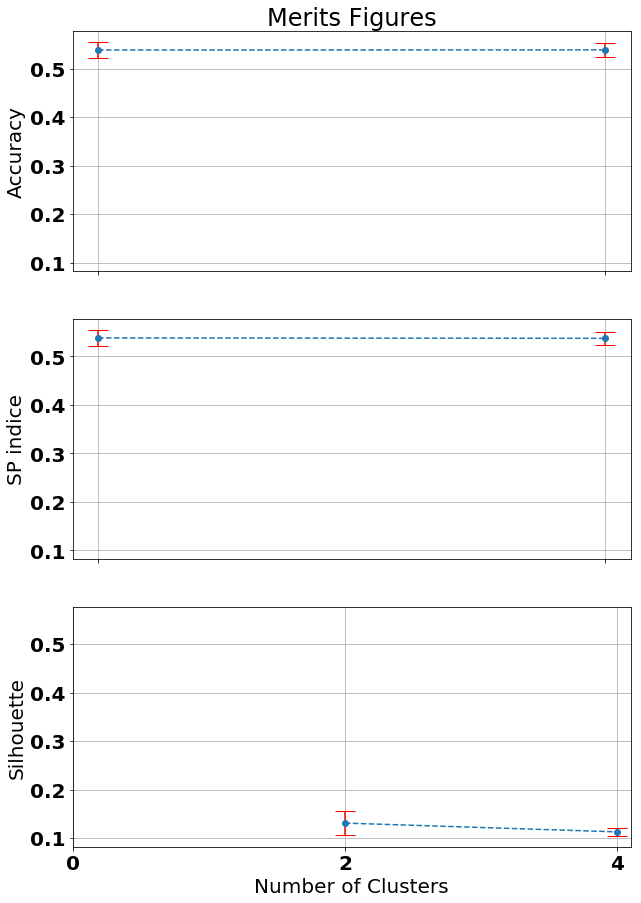

In [86]:
plt.figure(figsize=(10,10))

f, (ax1, ax2, ax3) = plt.subplots(3,figsize=(10,15), sharex=True, sharey=True)
ax1.errorbar(x, acc_mean, yerr=sigma_acc, fmt='--o',ecolor='r',capsize=10)
ax1.grid()
ax1.set_title('Merits Figures')
ax1.set_ylabel('Accuracy')
ax2.errorbar(x,SP_mean, yerr=sigma_SP, fmt='--o',ecolor='r',capsize=10)
ax2.set_ylabel('SP indice')
ax2.grid()
ax3.errorbar(x,sil_par_mean, yerr=sigma_par_sil,fmt='--o',ecolor='r',capsize=10)
ax3.set_ylabel('Silhouette')
ax3.grid()
ax3.set_xlabel('Number of Clusters')
ax3.set_xticks(np.arange(min(x)-2, max(x)+1, 2.0))
# Fine-tune figure; make subplots close to each other and hide x ticks for
# all but bottom plot.
#f.subplots_adjust(hspace=0)
#plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
#f.savefig(path_tosave+'/'+'figuras_3em1_semPtRel.pdf')

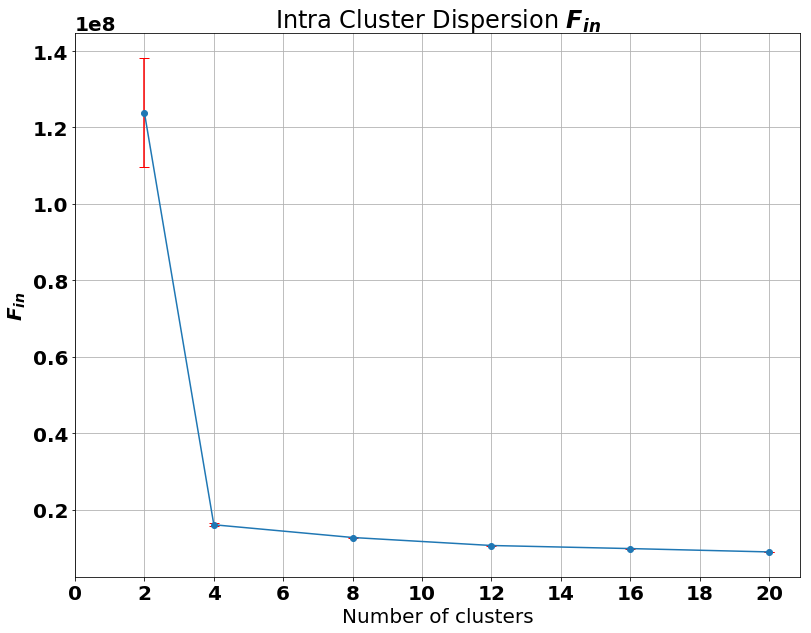

In [62]:
plt.rc('font', weight='bold', size=20)
plt.figure(figsize=(13,10))
plt.errorbar(x,Fin_mean,yerr=sigma_Fin,ecolor='r',fmt='-o',capsize=5)
plt.title(r'Intra Cluster Dispersion $F_{in}$')
plt.xlabel('Number of clusters')
plt.xticks(np.arange(min(x)-2, max(x)+1, 2.0))
plt.ylabel(r'$F_{in}$')
plt.grid()
#plt.savefig(path_tosave+'/'+'Fin_sup_plot_semPtRel.pdf')

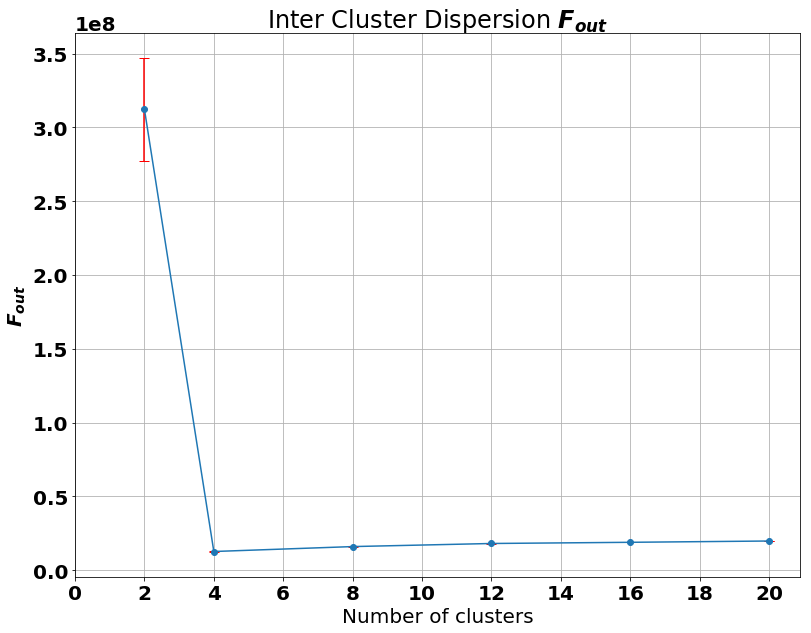

In [63]:
plt.rc('font', weight='bold', size=20)
plt.figure(figsize=(13,10))
plt.errorbar(x,Fout_mean,yerr=sigma_Fout,ecolor='r',fmt='-o',capsize=5)
plt.title(r'Inter Cluster Dispersion $F_{out}$')
plt.xlabel('Number of clusters')
plt.xticks(np.arange(min(x)-2, max(x)+1, 2.0))
plt.ylabel(r'$F_{out}$')
plt.grid()
#plt.savefig(path_tosave+'/'+'Fout_sup_plot_semPtRel.pdf')

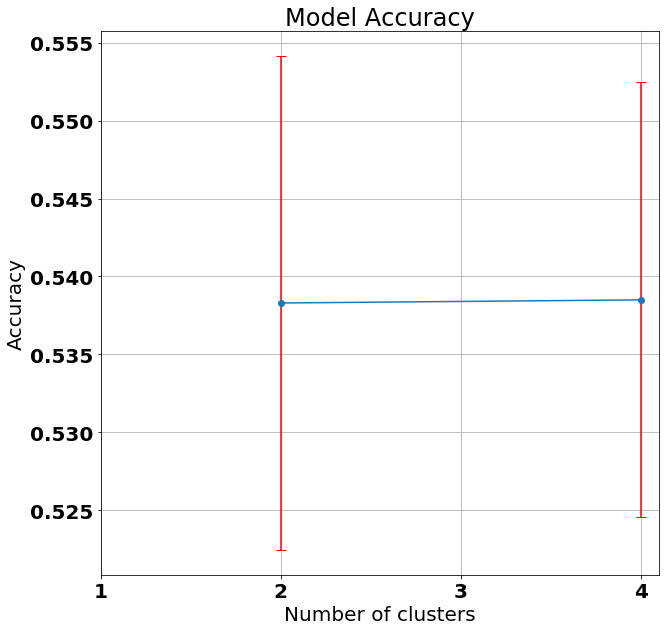

In [87]:
plt.rc('font', weight='bold', size=20)
plt.figure(figsize=(10,10))
plt.errorbar(x,acc_score_mean,yerr=sigma_acc_score,ecolor='r',fmt='-o',capsize=5)
plt.title('Model Accuracy')
plt.xlabel('Number of clusters')
plt.xticks(np.arange(min(x)-1, max(x)+1, 1.0))
plt.ylabel('Accuracy')
plt.grid()
#plt.savefig(path_tosave+'/'+'Accuracy_plot_semPtRel.pdf')

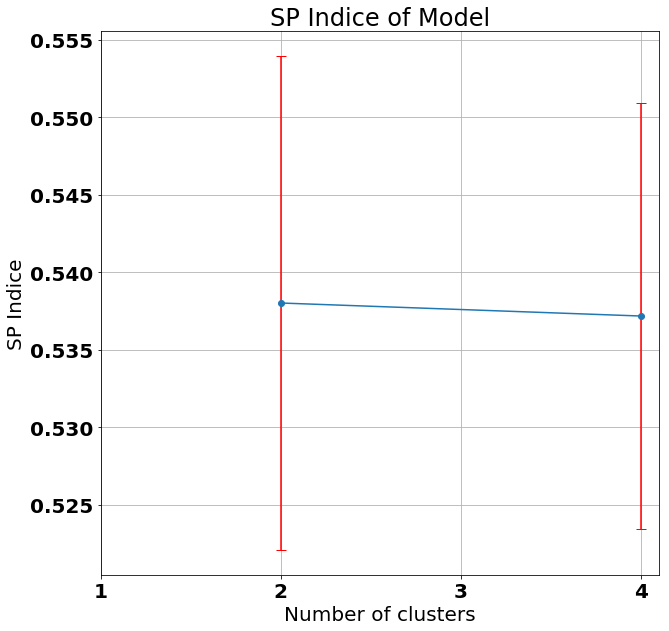

In [88]:
plt.figure(figsize=(10,10))
plt.errorbar(x,SP_mean,yerr=sigma_SP,ecolor='r',fmt='-o',capsize=5)
plt.title('SP Indice of Model')
plt.xlabel('Number of clusters')
plt.xticks(np.arange(min(x)-1, max(x)+1, 1.0))
plt.ylabel('SP Indice')
plt.grid()
#plt.savefig(path_tosave+'/'+'SPindex_plot_semPtRel.pdf')

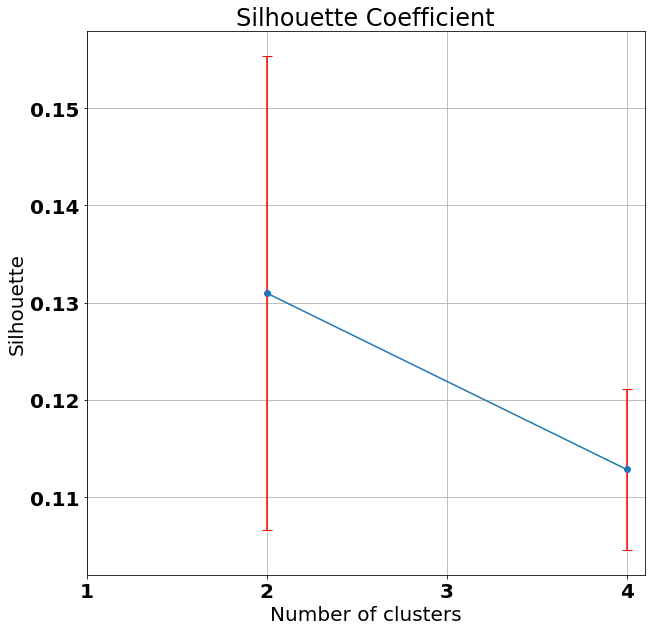

In [89]:
plt.figure(figsize=(10,10))
plt.errorbar(x,sil_par_mean,yerr=sigma_par_sil,ecolor='r',fmt='-o',capsize=5)
plt.title('Silhouette Coefficient')
plt.xlabel('Number of clusters')
plt.xticks(np.arange(min(x)-1, max(x)+1, 1.0))
plt.ylabel('Silhouette')
plt.grid()
#plt.savefig(path_tosave+'/'+'Silhouette_plot_semPtRel.pdf')

## Número de Clusters definido igual 8 ( 4 clusters para sinal e 4 clusters para ruído )

Treinamento e obtenção do resultado e matriz de confusão

In [5]:
# try to use the SupervisedKohonen 

from functions import SupervisedKohonen
from sklearn import cross_validation

trn_params = SupervisedKohonen.TrainParameters()

trn_params.learning_rate = 0.01

knn = SupervisedKohonen.KohonenNN()

In [62]:
data_signal = norm_data[trgt==1]
data_ttbar = norm_data[trgt==0]
ttbar_n_clusters=6
signal_n_clusters=6
kmeans_signal = KMeans(n_clusters=signal_n_clusters, random_state=0).fit_predict(data_signal)
kmeans_ttbar = KMeans(n_clusters=ttbar_n_clusters, random_state=0).fit_predict(data_ttbar)

new_trgt = np.append((kmeans_signal+ttbar_n_clusters),kmeans_ttbar)

np.unique(new_trgt)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=int32)

In [103]:
n_folds = 10
n_inits = 1

CVO = cross_validation.StratifiedKFold(trgt,n_folds)
CVO = list(CVO)

classifiers = {}

for ifold in range(n_folds):
    train_id, test_id = CVO[ifold]
    for i_init in range(n_inits):
        print ('Processing: Fold %i of %i Init %i of %i'%(
                ifold+1, n_folds, 
                i_init+1, n_inits))
        
        scale_signal = preprocessing.StandardScaler().fit(data[train_id][trgt[train_id]==1])
        scale_ttbar = preprocessing.StandardScaler().fit(data[train_id][trgt[train_id]==0])

        norm_factor = np.zeros_like(scale_signal.scale_)
        norm_factor = np.transpose(norm_factor)
        for i in range(norm_factor.shape[0]):
            norm_factor[i] = min(scale_signal.scale_[i],scale_ttbar.scale_[i])

        norm_data = preprocessing.scale(data,with_std=False)

        for i in range(norm_data.shape[1]):
            norm_data[:,i] = (1/norm_factor[i])*norm_data[:,i]


        for i in range(norm_data.shape[1]):
            norm_data[:,i] = (1/norm_factor[i])*norm_data[:,i]

                                                                         
        data_signal = norm_data[trgt==1]
        data_ttbar = norm_data[trgt==0]

        kmeans_signal = KMeans(n_clusters=2, random_state=0).fit(norm_data[train_id][trgt[train_id]==1])
        kmeans_output_signal = kmeans_signal.predict(data_signal)
        
        kmeans_ttbar = KMeans(n_clusters=2, random_state=0).fit(norm_data[train_id][trgt[train_id]==0])
        kmeans_output_ttbar = kmeans_ttbar.predict(data_ttbar)
        
        new_trgt = np.append((kmeans_output_signal+2),kmeans_output_ttbar)
        
        knn.fit(norm_data[train_id],new_trgt[train_id],trn_params=trn_params)
        classifiers[ifold] = knn

Processing: Fold 1 of 10 Init 1 of 1
Supervised Kohonen NN TrainParameters
Learning Rate: 0.01000
Verbose: False
Number of events: 9000
Processing: Fold 2 of 10 Init 1 of 1
Supervised Kohonen NN TrainParameters
Learning Rate: 0.01000
Verbose: False
Number of events: 9000
Processing: Fold 3 of 10 Init 1 of 1
Supervised Kohonen NN TrainParameters
Learning Rate: 0.01000
Verbose: False
Number of events: 9000
Processing: Fold 4 of 10 Init 1 of 1
Supervised Kohonen NN TrainParameters
Learning Rate: 0.01000
Verbose: False
Number of events: 9000
Processing: Fold 5 of 10 Init 1 of 1
Supervised Kohonen NN TrainParameters
Learning Rate: 0.01000
Verbose: False
Number of events: 9000
Processing: Fold 6 of 10 Init 1 of 1
Supervised Kohonen NN TrainParameters
Learning Rate: 0.01000
Verbose: False
Number of events: 9000
Processing: Fold 7 of 10 Init 1 of 1
Supervised Kohonen NN TrainParameters
Learning Rate: 0.01000
Verbose: False
Number of events: 9000
Processing: Fold 8 of 10 Init 1 of 1
Supervised 

In [ ]:
# not work
# all classifiers saved
knn.save_model(data_path+'/'+'model_2clusters.pk1')

In [ ]:
teste = joblib.load(data_path+'/'+'model_2clusters.pk1')

teste.sinapses

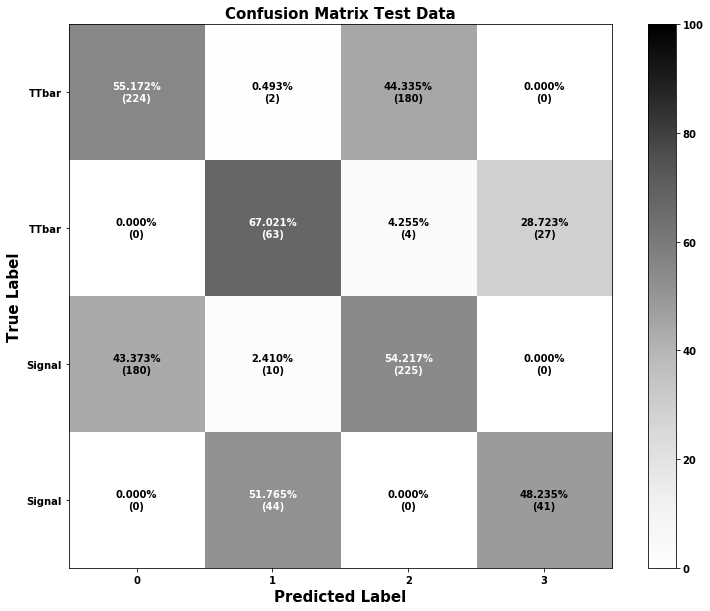

In [104]:
# confusion matrix for supervised Kohonen

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix

data_labels = ['TTbar','TTbar','Signal','Signal']
plt.rcParams['font.weight'] = 'bold'
#output_class = Output
choose_fold = 0
#print 'Fold: ', choose_fold
train_id, test_id = CVO[choose_fold]

knn_output = classifiers[choose_fold].predict(norm_data)

#SP = ClusterMerits.SP(Output,trgt)
#print 'SP = ', SP

#acc = np.mean(ClusterMerits.Acc(Output,trgt))
#print 'Accuracy', acc

cm = confusion_matrix(new_trgt[test_id], knn_output[test_id])
cm_data = cm
cm = cm.astype('float')/ cm.sum(axis=1)[:, np.newaxis]
cm_normalized = 100.*cm

fig = plt.figure(figsize=(13,10))
ax = fig.add_subplot(111)
ax.set_aspect(1)

im = ax.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Greys,clim=(0.0, 100.0))

width, height = cm_normalized.shape


for x in xrange(width):
    for y in xrange(height):
        if cm_normalized[x][y] < 50.:
            ax.annotate('%1.3f%%\n(%i)'%(cm_normalized[x][y],cm_data[x][y]), xy=(y, x),
                        horizontalalignment='center',
                        verticalalignment='center')
        else:
            ax.annotate('%1.3f%%\n(%i)'%(cm_normalized[x][y],cm_data[x][y]), xy=(y, x),
                        horizontalalignment='center',
                        verticalalignment='center',color='white')

ax.set_title('Confusion Matrix Test Data',fontweight='bold',fontsize=15)
fig.colorbar(im)

tick_marks = np.arange(len(data_labels))
ax.xaxis.set_ticks(tick_marks)
#ax.xaxis.set_ticklabels(data_labels)

ax.yaxis.set_ticks(tick_marks)
ax.yaxis.set_ticklabels(data_labels)

ax.set_ylabel('True Label',fontweight='bold',fontsize=15)
ax.set_xlabel('Predicted Label',fontweight='bold',fontsize=15)
fig.savefig(path_tosave+'/'+'ConfusionMatrixSupKohonen_4clustersTEST.pdf')
#fig.savefig(path_tosave+'/'+'ConfusionMatrixSupKohonen_5clustersttbar-4clustersignalTEST_BACKUP.pdf')

In [61]:
cluster_matrix = ConfusionMatrix(new_trgt[test_id], knn_output[test_id])
print norm_data[trgt[test_id]==0].shape[0]
print("Confusion matrix:\n%s" % cluster_matrix)

501
Confusion matrix:
Predicted  0.0  1.0  2.0  3.0  4.0  5.0  6.0  7.0  __all__
Actual                                                    
0.0         71    0    0    0    2   26    0    9      108
1.0          0   35    0    0    0    0    0    0       35
2.0          0    0   85    0   12    0   58   50      205
3.0          0    1    0  115    7    3    0   27      153
4.0          1    0    0    1   42    1    0    0       45
5.0         40    0    0    2    0   84    0    0      126
6.0          0    0   63    0    0    0   74    0      137
7.0          0    0   11   22    0    1    4  156      194
__all__    112   36  159  140   63  115  136  242     1003


/home/micael/.virtualenvs/MyAnalysis/lib/python2.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 10000 but corresponding boolean dimension is 1003
  


In [105]:
acc = np.mean(ClusterMerits.Acc(knn_output,new_trgt))
print 'Accuracy: ', round(acc,3)

print 'Acc Score: ', round(metrics.accuracy_score(knn_output,new_trgt),3)

SP = ClusterMerits.SP(knn_output,new_trgt)
print 'SP: ', round(SP,3)

Sil = metrics.silhouette_score(norm_data,new_trgt)
print 'Silhueta: ', round(Sil,3)

Accuracy:  0.546
Acc Score:  0.54
SP:  0.545
Silhueta:  -0.001


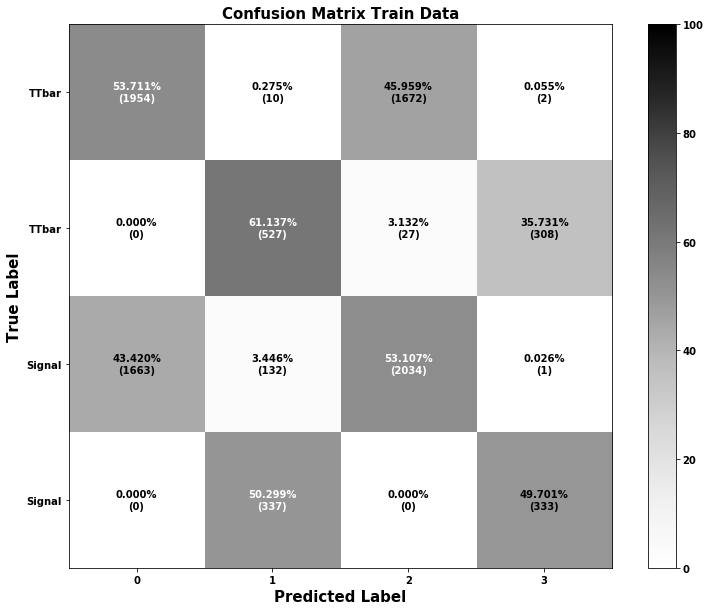

In [106]:
cm = confusion_matrix(new_trgt[train_id], knn_output[train_id])
cm_data = cm
cm = cm.astype('float')/ cm.sum(axis=1)[:, np.newaxis]
cm_normalized = 100.*cm

fig = plt.figure(figsize=(13,10))
ax = fig.add_subplot(111)
ax.set_aspect(1)

im = ax.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Greys,clim=(0.0, 100.0))

width, height = cm_normalized.shape


for x in xrange(width):
    for y in xrange(height):
        if cm_normalized[x][y] < 50.:
            ax.annotate('%1.3f%%\n(%i)'%(cm_normalized[x][y],cm_data[x][y]), xy=(y, x),
                        horizontalalignment='center',
                        verticalalignment='center')
        else:
            ax.annotate('%1.3f%%\n(%i)'%(cm_normalized[x][y],cm_data[x][y]), xy=(y, x),
                        horizontalalignment='center',
                        verticalalignment='center',color='white')

ax.set_title('Confusion Matrix Train Data',fontweight='bold',fontsize=15)
fig.colorbar(im)

tick_marks = np.arange(len(data_labels))
ax.xaxis.set_ticks(tick_marks)
#ax.xaxis.set_ticklabels(data_labels)

ax.yaxis.set_ticks(tick_marks)
ax.yaxis.set_ticklabels(data_labels)

ax.set_ylabel('True Label',fontweight='bold',fontsize=15)
ax.set_xlabel('Predicted Label',fontweight='bold',fontsize=15)
fig.savefig(path_tosave+'/'+'ConfusionMatrixSupKohonen_4clustersTRAIN.pdf')
#fig.savefig(path_tosave+'/'+'ConfusionMatrixSupKohonen_5clustersttbar-4clustersignalTRAIN_BACKUP.pdf')

In [108]:
np.unique(knn_output)

array([ 0.,  1.,  2.,  3.])

In [113]:
# create a final classification for signal and bkg

class_final = np.zeros(trgt.shape)
for i in range(knn_output.shape[0]):
    if knn_output[i] in range(len(np.unique(knn_output))/2):
        #print 'bkg'
        class_final[i]=0
    else:
        #print 'signal'
        class_final[i]=1
        
np.unique(class_final)


array([ 0.,  1.])

In [114]:
# merit figures
print 'Acc: ', round(np.mean(ClusterMerits.Acc(class_final,trgt)),3)
print 'Acc Score:', round(metrics.accuracy_score(trgt[test_id],class_final[test_id]),3)
print 'Indice SP: ',round(ClusterMerits.SP(class_final,trgt),3)
print 'Silhuet Coeficient: ',round(metrics.silhouette_score(norm_data,class_final),3)
#print 'Acuracy_score: ', metrics.accuracy_score(trgt,class_final)
#print 'completness score: ', metrics.completeness_score(trgt,class_final)
print 'v mesure: ', metrics.v_measure_score(trgt,class_final)

Acc:  0.541
Acc Score: 0.555
Indice SP:  0.541
Silhuet Coeficient:  0.063
v mesure:  0.00495688363324


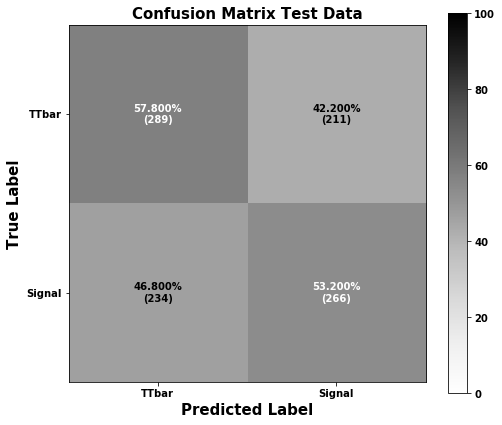

In [115]:
data_labels = ['TTbar','Signal']
plt.rcParams['font.weight'] = 'bold'

cm = confusion_matrix(trgt[test_id], class_final[test_id])
cm_data = cm
cm = cm.astype('float')/ cm.sum(axis=1)[:, np.newaxis]
cm_normalized = 100.*cm

fig = plt.figure(figsize=(8,7))
ax = fig.add_subplot(111)
ax.set_aspect(1)

im = ax.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Greys,clim=(0.0, 100.0))

width, height = cm_normalized.shape


for x in xrange(width):
    for y in xrange(height):
        if cm_normalized[x][y] < 50.:
            ax.annotate('%1.3f%%\n(%i)'%(cm_normalized[x][y],cm_data[x][y]), xy=(y, x),
                        horizontalalignment='center',
                        verticalalignment='center')
        else:
            ax.annotate('%1.3f%%\n(%i)'%(cm_normalized[x][y],cm_data[x][y]), xy=(y, x),
                        horizontalalignment='center',
                        verticalalignment='center',color='white')

ax.set_title('Confusion Matrix Test Data',fontweight='bold',fontsize=15)
fig.colorbar(im)

tick_marks = np.arange(len(data_labels))
ax.xaxis.set_ticks(tick_marks)
ax.xaxis.set_ticklabels(data_labels)

ax.yaxis.set_ticks(tick_marks)
ax.yaxis.set_ticklabels(data_labels)

ax.set_ylabel('True Label',fontweight='bold',fontsize=15)
ax.set_xlabel('Predicted Label',fontweight='bold',fontsize=15)
plt.savefig(path_tosave+'/'+'ConfusionMatrixClassfinal_4clustersTEST_FINAL.pdf')
#fig.savefig(path_tosave+'/'+'ConfusionMatrixClassfinal_5clustersttbar-4clustersignalTEST_BACKUP.pdf')

0.6822709163346613

In [67]:

conf_matrix = ConfusionMatrix(trgt[test_id], class_final[test_id])
print("Confusion matrix:\n%s" % conf_matrix)
#conf_matrix.print_stats()

Confusion matrix:
Predicted  0.0  1.0  __all__
Actual                      
0.0        307  194      501
1.0        140  362      502
__all__    447  556     1003


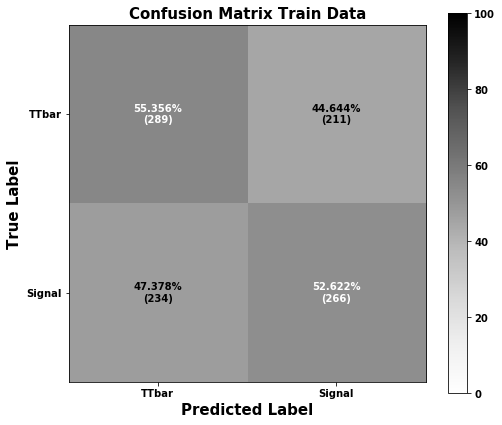

In [116]:
cm = confusion_matrix(trgt[train_id], class_final[train_id])
cm = cm.astype('float')/ cm.sum(axis=1)[:, np.newaxis]
cm_normalized = 100.*cm

fig = plt.figure(figsize=(8,7))
ax = fig.add_subplot(111)
ax.set_aspect(1)

im = ax.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Greys,clim=(0.0, 100.0))

width, height = cm_normalized.shape


for x in xrange(width):
    for y in xrange(height):
        if cm_normalized[x][y] < 50.:
            ax.annotate('%1.3f%%\n(%i)'%(cm_normalized[x][y],cm_data[x][y]), xy=(y, x),
                        horizontalalignment='center',
                        verticalalignment='center')
        else:
            ax.annotate('%1.3f%%\n(%i)'%(cm_normalized[x][y],cm_data[x][y]), xy=(y, x),
                        horizontalalignment='center',
                        verticalalignment='center',color='white')

ax.set_title('Confusion Matrix Train Data',fontweight='bold',fontsize=15)
fig.colorbar(im)

tick_marks = np.arange(len(data_labels))
ax.xaxis.set_ticks(tick_marks)
ax.xaxis.set_ticklabels(data_labels)

ax.yaxis.set_ticks(tick_marks)
ax.yaxis.set_ticklabels(data_labels)

ax.set_ylabel('True Label',fontweight='bold',fontsize=15)
ax.set_xlabel('Predicted Label',fontweight='bold',fontsize=15)
plt.savefig(path_tosave+'/'+'ConfusionMatrixClassfinal_4clustersTRAIN_FINAL.pdf')
#fig.savefig(path_tosave+'/'+'ConfusionMatrixClassfinal_5clustersttbar-4clustersignalTRAIN_BACKUP.pdf')

In [ ]:
print class_final[test_id].shape
np.sum(class_final[trgt[test_id]==-1]==-1)/float(501)

/home/micael/.virtualenvs/MyAnalysis/lib/python2.7/site-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 10000 but corresponding boolean dimension is 1002
  # This is added back by InteractiveShellApp.init_path()
/home/micael/.virtualenvs/MyAnalysis/lib/python2.7/site-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 10000 but corresponding boolean dimension is 1002
  if sys.path[0] == '':


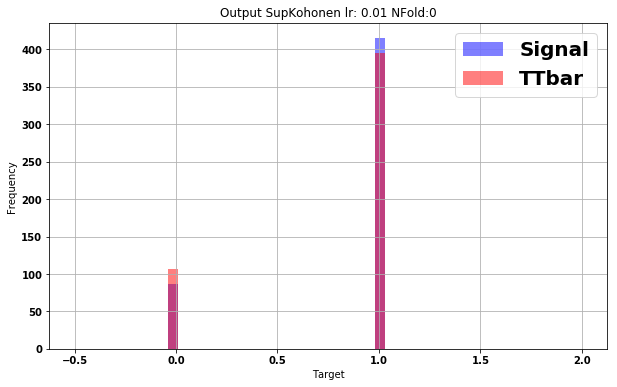

In [51]:
#choose_fold = 7

#train_id, test_id = CVO[choose_fold]

#Output = classifiers[choose_fold].predict(data)


fig = plt.figure(figsize=(10,6))
my_bins = np.linspace(-0.5,2, 50)
#print output_class.shape
plt.hist(class_final[trgt[test_id]==1],bins=my_bins,color='b',alpha=0.5,label='Signal')
plt.hist(class_final[trgt[test_id]==0],bins=my_bins,color='r',alpha=0.5,label='TTbar')
plt.legend(fontsize=20,loc='best')
plt.title('Output SupKohonen lr: '+str(trn_params.learning_rate)+' NFold:'+str(choose_fold))
plt.xlabel("Target")
plt.ylabel("Frequency")
plt.grid()
#plt.savefig(path_tosave+'/'+'Output_SupKohonenNormalized_Silhouette.pdf')
plt.show()

In [46]:
print sum(class_final[trgt[test_id]==0]==0)

218


/home/micael/.virtualenvs/MyAnalysis/lib/python2.7/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 10000 but corresponding boolean dimension is 1002
  if __name__ == '__main__':


In [40]:
lista =[i for i in range(3)]
lista

[0, 1, 2]

In [ ]:
import joblib 

joblib.dump(new_classifiers[choose_fold],path_tosave+'/'+'ultimoModelo.pk1')



In [ ]:
import joblib

model = joblib.load(path_tosave+'/'+'ultimoModelo.pk1')

model.sinapses